# EDA 

In this notebook, we will be doing final cleaning to get the data ready for modeling, as well as some EDA.

Here are some questions and hypotheses we might consider during EDA: 

##### Genre-Related:
- Do certain genres consistently receive higher or lower ratings?
- Are there specific genre combinations that fare better or worse?
- How does genre interact with other variables like budget or box office gross? Do high-budget action movies get better ratings than low-budget ones?

##### Budget and Box Office Gross:
- Does a higher budget correlate with a higher rating?
- Does box office performance predict the rating, or vice versa?

##### Text-Related:
- Does the sentiment expressed in the reviews correlate with the movie's rating?
- Do movies with more polarized reviews (i.e., many very positive and very negative reviews) have a different distribution of ratings?

##### Others:
- Are newer movies rated differently than older ones?
- Does runtime influence ratings?
- How do variables like director, cast, etc., influence the ratings?
- Are movies with certain keywords or sentiments in their reviews more likely to fall into a particular rating category?

Let's start by loading our basic packages and our two datasets (metadata and reviews).

In [2]:
#Importing the packages we will be using
# Basic Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load metadata
metadata_df = pd.read_json('data/final_data/final_metadata_clean.json', lines=True)

In [4]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49379 entries, 0 to 49378
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               49379 non-null  object 
 1   title                 49379 non-null  object 
 2   actors                49379 non-null  object 
 3   directors             49379 non-null  object 
 4   genres                49379 non-null  object 
 5   language_en           49379 non-null  int64  
 6   year                  49379 non-null  int64  
 7   runtime               49379 non-null  int64  
 8   budget                17818 non-null  float64
 9   box_office_gross      21049 non-null  float64
 10  production_companies  49379 non-null  object 
 11  votes                 49379 non-null  int64  
 12  rating                49379 non-null  float64
dtypes: float64(3), int64(4), object(6)
memory usage: 4.9+ MB


In [64]:
# Load reviews 
reviews_df = pd.read_json('data/final_data/final_reviews_filtered_en.json', lines=True)

In [65]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147256 entries, 0 to 3147255
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   imdb_id      object
 1   review_text  object
 2   language     object
dtypes: object(3)
memory usage: 72.0+ MB


Let's do a check to make sure we have the expected number of common `imdb_id`s between our two datasets.

In [66]:
unique_imdb_ids = metadata_df['imdb_id'].nunique()
print(f"Number of unique imdb_id: {unique_imdb_ids}")

Number of unique imdb_id: 49379


In [67]:
unique_imdb_ids = reviews_df['imdb_id'].nunique()
print(f"Number of unique imdb_id: {unique_imdb_ids}")

Number of unique imdb_id: 49379


##### Keep dataframes separate for now
Since our reviews dataset is quite large, we will perform some EDA on each dataset separately before merging.

##### Starting with the basics 
We'll start with simple descriptive statistics and distributions on our numerical columns from `metadata`.

In [5]:
# Save numerical columns to a list 
numerical_columns = metadata_df[['year', 'runtime', 'budget', 'box_office_gross', 'votes', 'rating']]

In [6]:
# Get summary stats for numerical columns
round(numerical_columns.describe(),2)

,year,runtime,budget,box_office_gross,votes,rating
count,49379.00,49379.00,1.781800e+04,2.104900e+04,49379.00,49379.00
mean,1989.76,96.98,1.367277e+07,1.709322e+07,18538.68,6.16
std,24.25,25.98,6.800317e+07,4.630648e+07,82404.78,1.15
min,1902.00,1.00,0.000000e+00,1.000000e+00,9.00,1.20
25%,1973.00,87.00,9.442500e+05,1.644800e+05,559.00,5.50
50%,1998.00,95.00,3.500000e+06,1.526697e+06,1631.00,6.30
75%,2010.00,106.00,1.300000e+07,1.329037e+07,5932.50,7.00
max,2018.00,780.00,8.370767e+09,2.187464e+09,2798663.00,9.40


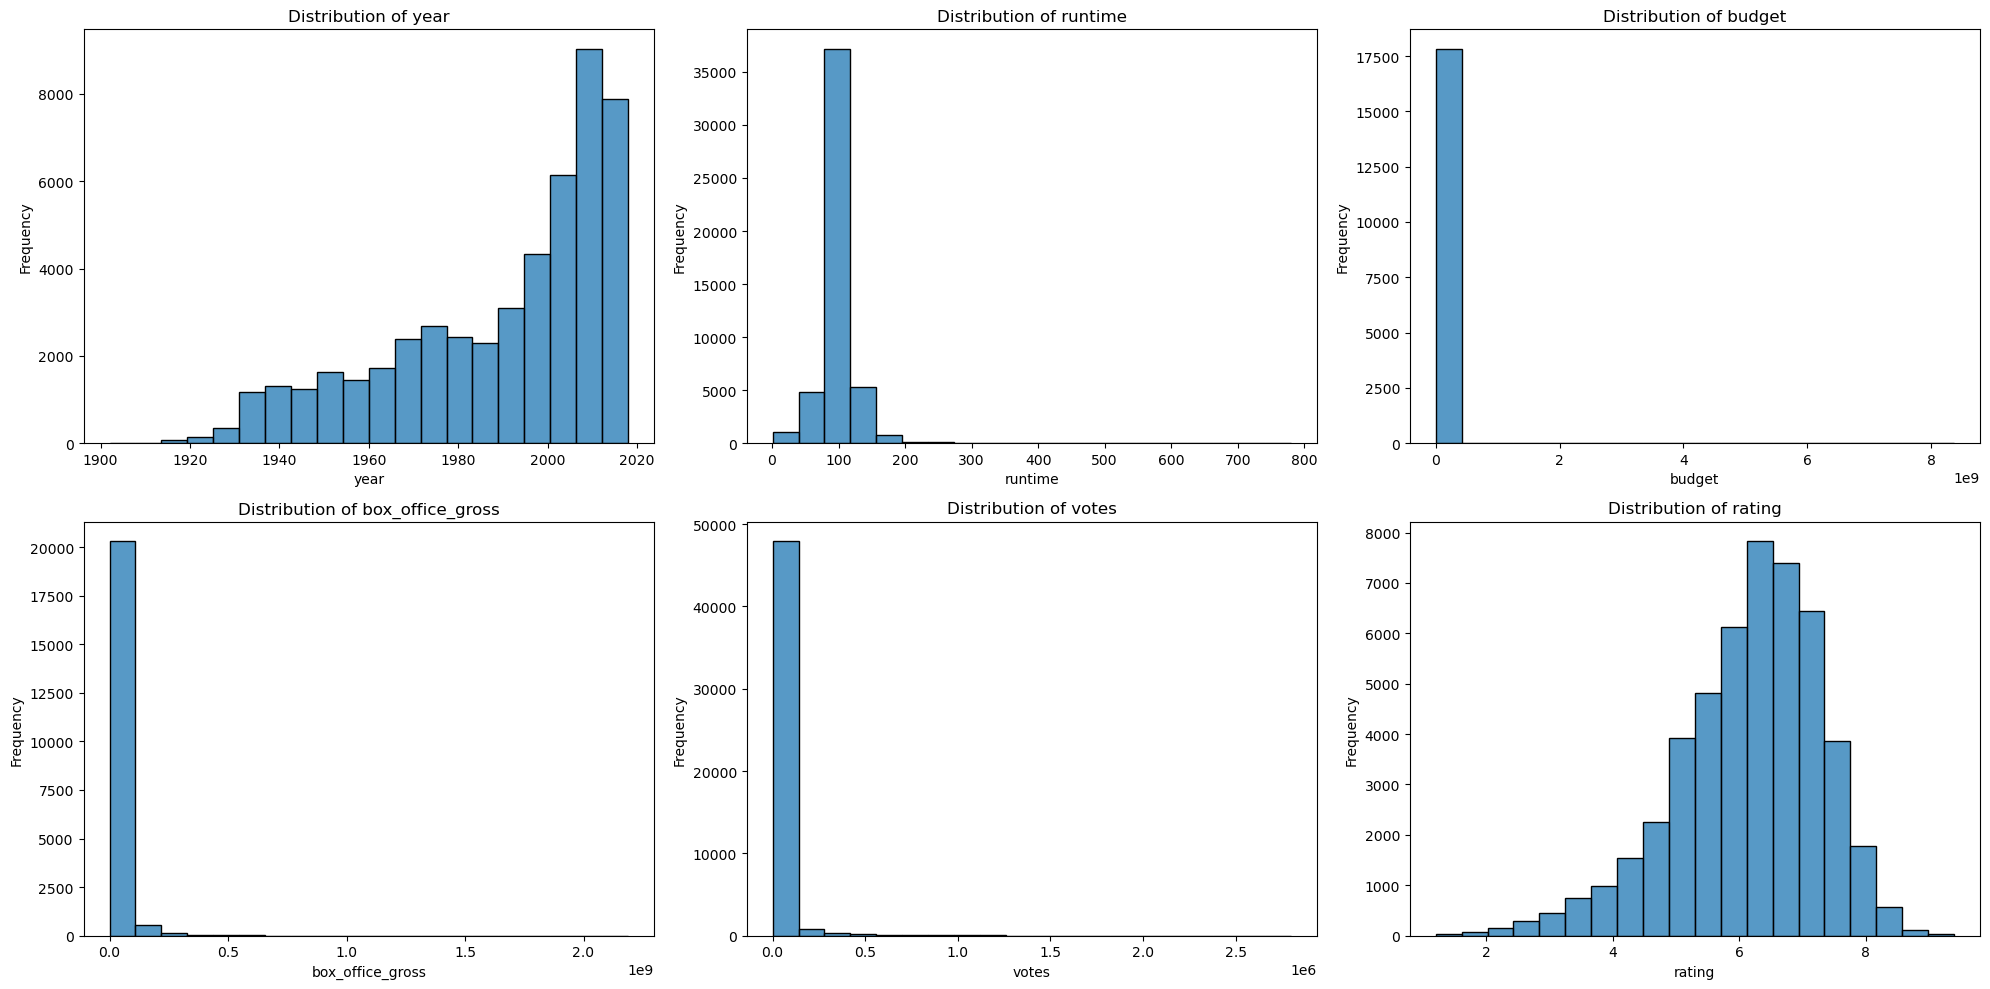

In [11]:
# Look at distributions of numerical features 

rows = 2
cols = 3 

plt.figure(figsize=(20, 10)) 

# Loop through each numerical column
for i, col in enumerate(numerical_columns):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(metadata_df[col], bins=20, kde=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Observations

- **Year**: The dataset includes movies ranging from the year 1902 to 2018. The median year (50th percentile) is 1999, indicating that half of the movies in the dataset were made after 1999.

- **Runtime**: The average runtime for movies is approximately 98 minutes. There's a significant range, from a minimum of 1 minute to a maximum of 1256 minutes (over 20 hours), which suggests some potential outliers that may need to be addressed.

- **Budget**: Budget data is missing for many rows (only about 17,938 entries out of 49,953 have budget information). The average budget is about 13.7 million USD.

- **Box Office Gross**: The average box office gross is approximately 17 million USD. It ranges from 1 USD to about 2.18 billion USD.

- **Votes**: The number of votes also varies widely, from a minimum of 9 to a maximum of about 2.8 million. The average number of votes is around 18,426, but the high standard deviation suggests the data is very spread out.

- **Rating**: The IMDb ratings range from 1.2 to 9.4, with an average rating of approximately 6.17. The distribution seems somewhat normal with 50% of the data between 5.5 and 7.0.

We can also note that there are significant outliers in almost every feature. We will most certainly have to scale our data, and perhaps decide if any of the outliers should be dropped. 

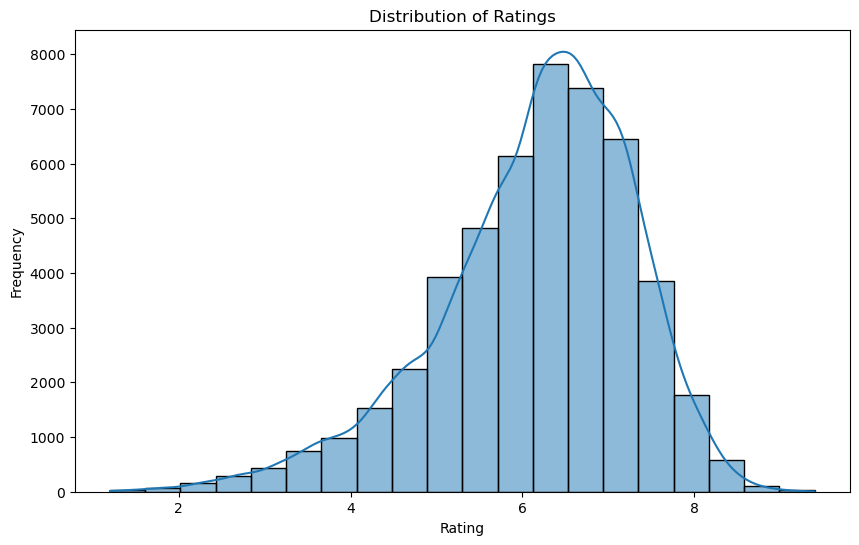

In [14]:
# Taking a closer look at ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(metadata_df['rating'], bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

#### Addressing Skewness

**Year**: Left-skewed data with a long tail stretching toward the earlier years. A skew towards newer movies suggests that the model will be more representative of trends in newer films. This could be problematic if we were only interested in making predictions that generalize across the entire history of film, but in a real world application of our model, we would be looking to predict the rating of new projects, so the entire history of film wouldn't be as significant. But we should keep in mind that the model might not generalize well to older movies.

Since our primary focus would be on understanding and predicting the reception of contemporary projects, then having a dataset skewed towards newer films isn't necessarily a disadvantage. In fact, it might even be an asset, as it makes the model more attuned to current tastes, trends, and other factors that could influence a movie's reception today.

**Runtime**: Right-skewed with a long tail stretching towards higher runtimes. Most movies appear to be concentrated in the 50-200 minute range, but there are outliers that go up to 800 minutes. The skewness in runtime might reflect the industry standard for feature films, which generally fall between 90-120 minutes. Extremely long films are relatively rare and could represent special cases like extended editions or miniseries. Since the objective is predicting ratings for contemporary projects, a skew towards the average industry runtime might not be an issue, as it likely aligns well with the types of films being produced today.

**Budget & Box Office Gross** Extremely right skewed. We only have data for less than half of our films here, so we will be imputing the data later and scaling it. In the context of film success, extremely high or low budgets can be notable and meaningful, as can very high box office gross. Therefore, keeping these as they are might capture this nuanced relationship. We could potentially bin the budget amounts into "high" "low" etc. but for baseline modeling, we'll probably leave them as is.

**Votes**: Again, the data is extremely right skewed. Scaling the data will help somewhat, but we could also consider a log transformation. However, once again in the context of real-wrorld film success, a high number of votes typically indicates a popular or widely-viewed film, which could be relevant. The extreme skewness could be capturing the phenomena of "viral hits" in the film industry.

**Rating**: This is the most normal of all our distributions, which is a good sign, given that it's our target variable. The concentration of ratings around 6 to 8 suggests that most films are perceived as being "average" or "above average," which aligns with a sort of "grading curve" mindset. Extremely poor or superb films are outliers. The clustering or ratings around the "above-average" range could also offer a way of viewing audience expectations or industry standards. We probably don't need to perform any transformation on this feature.

Ultimately, most of the skewness here provides real world context about what defines success in the film industry, and we could make an argument for leaving it in the dataset, at least for our first model. Let's look at log transformations of our skewed features just to be thorough.

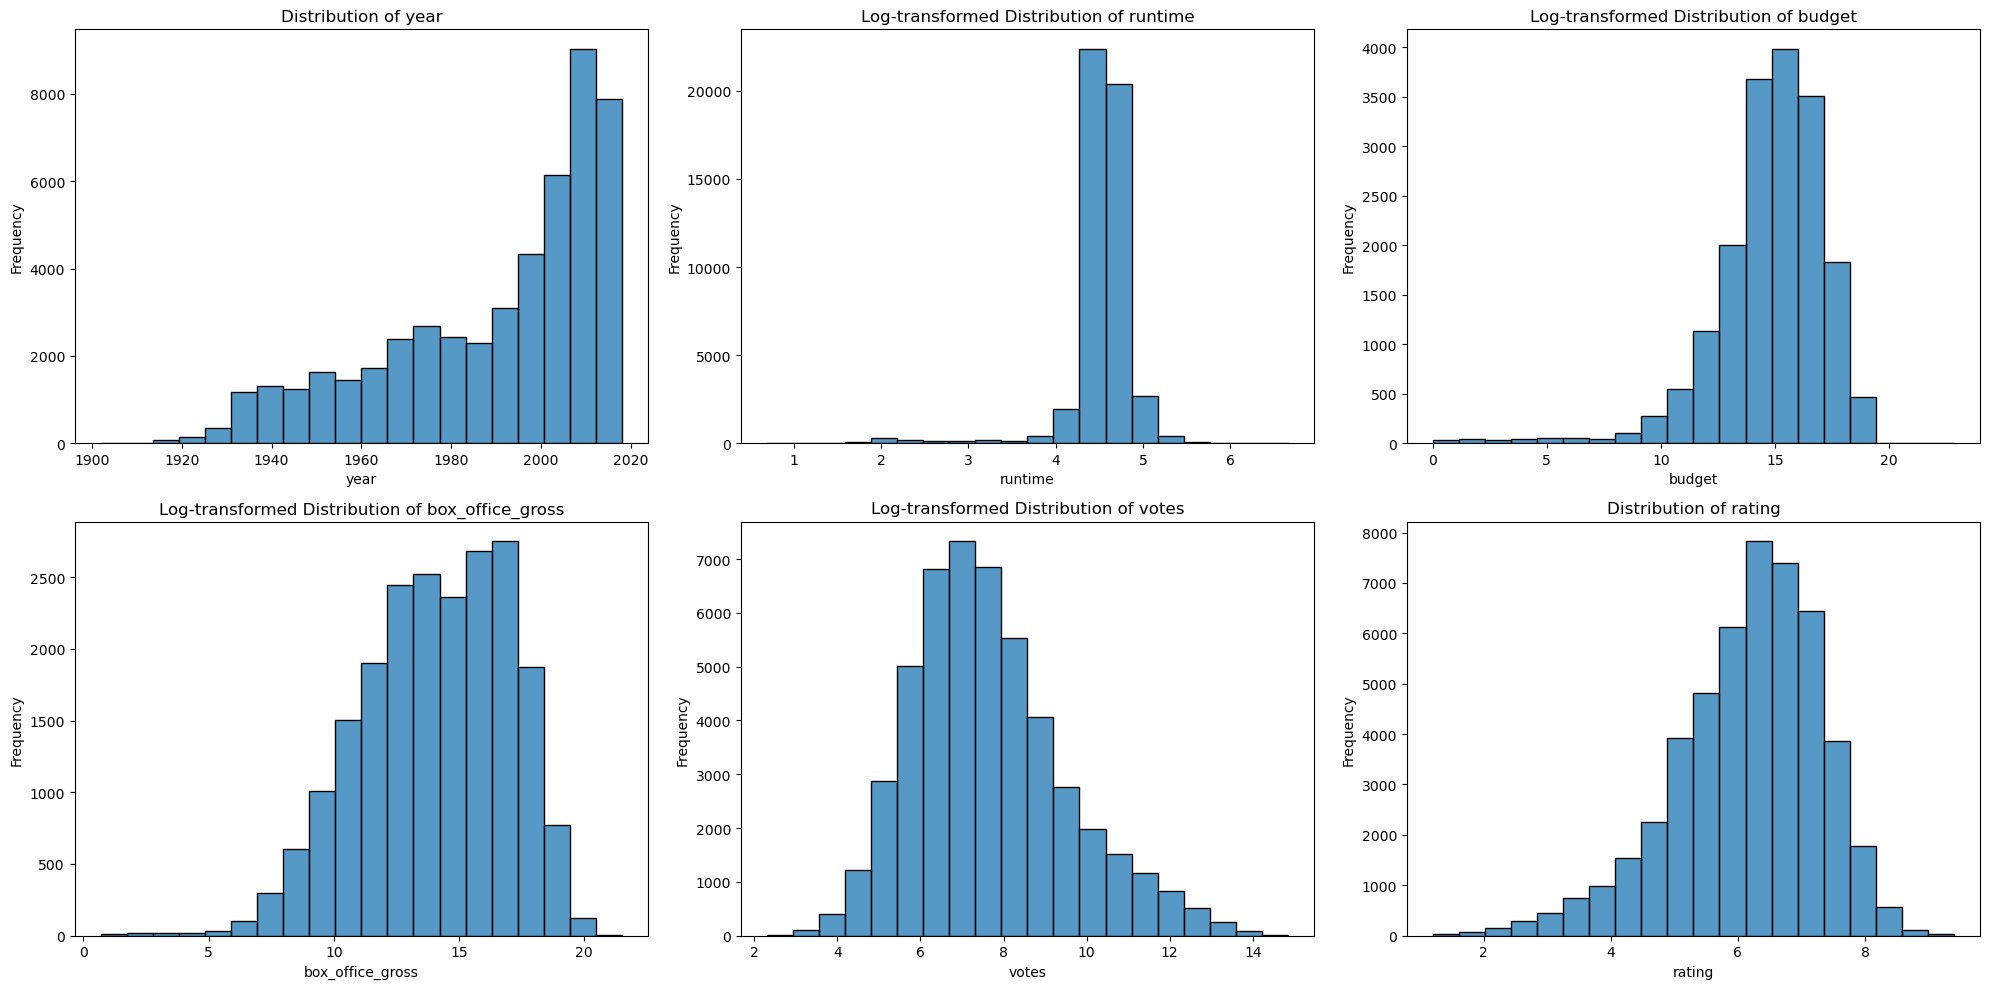

In [9]:
# Save columns to log transform 
log_transform_columns = ['runtime', 'budget', 'box_office_gross', 'votes']

rows = 2
cols = 3

plt.figure(figsize=(20, 10))  

# Loop through each numerical column
for i, col in enumerate(numerical_columns):
    plt.subplot(rows, cols, i + 1)
    
    # Check if the current column should be log-transformed
    if col in log_transform_columns:
        data_to_plot = np.log1p(metadata_df[col])
        plt.title(f'Log-transformed Distribution of {col}')
    else:
        data_to_plot = metadata_df[col]
        plt.title(f'Distribution of {col}')
    
    sns.histplot(data_to_plot, bins=20, kde=False)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Let's take a closer look at some of the actual outlier numbers as well.

In [13]:
## Budget Outliers

# Count the number of budgets below 100,000
count_below_500k = sum(metadata_df['budget'] < 100000)

print(f"There are {count_below_500k} movies with budgets below 100,000.")

There are 1247 movies with budgets below 100,000.


In [14]:
## Runtime Outliers 

# Count the number of runtimes above 300 minutes
long_movies_count = metadata_df[metadata_df['runtime'] > 300].shape[0]

print(f"Number of movies with runtime longer than 300 mins: {long_movies_count}")

Number of movies with runtime longer than 300 mins: 40


##### Pair plots and Correlation Matrix 
Now we'll look at pair plots and a correlation matrix to see if there are any linear relationships or any strong correlations between our features and the target variable. We'll create a temporary dataframe and drop the null values so the plots will show up correcctly. 

In [15]:
# Drop rows with missing values
dropna_df = metadata_df.dropna()

# Select numerical columns
numeric_columns = ['year', 'runtime', 'budget', 'box_office_gross', 'votes', 'rating']

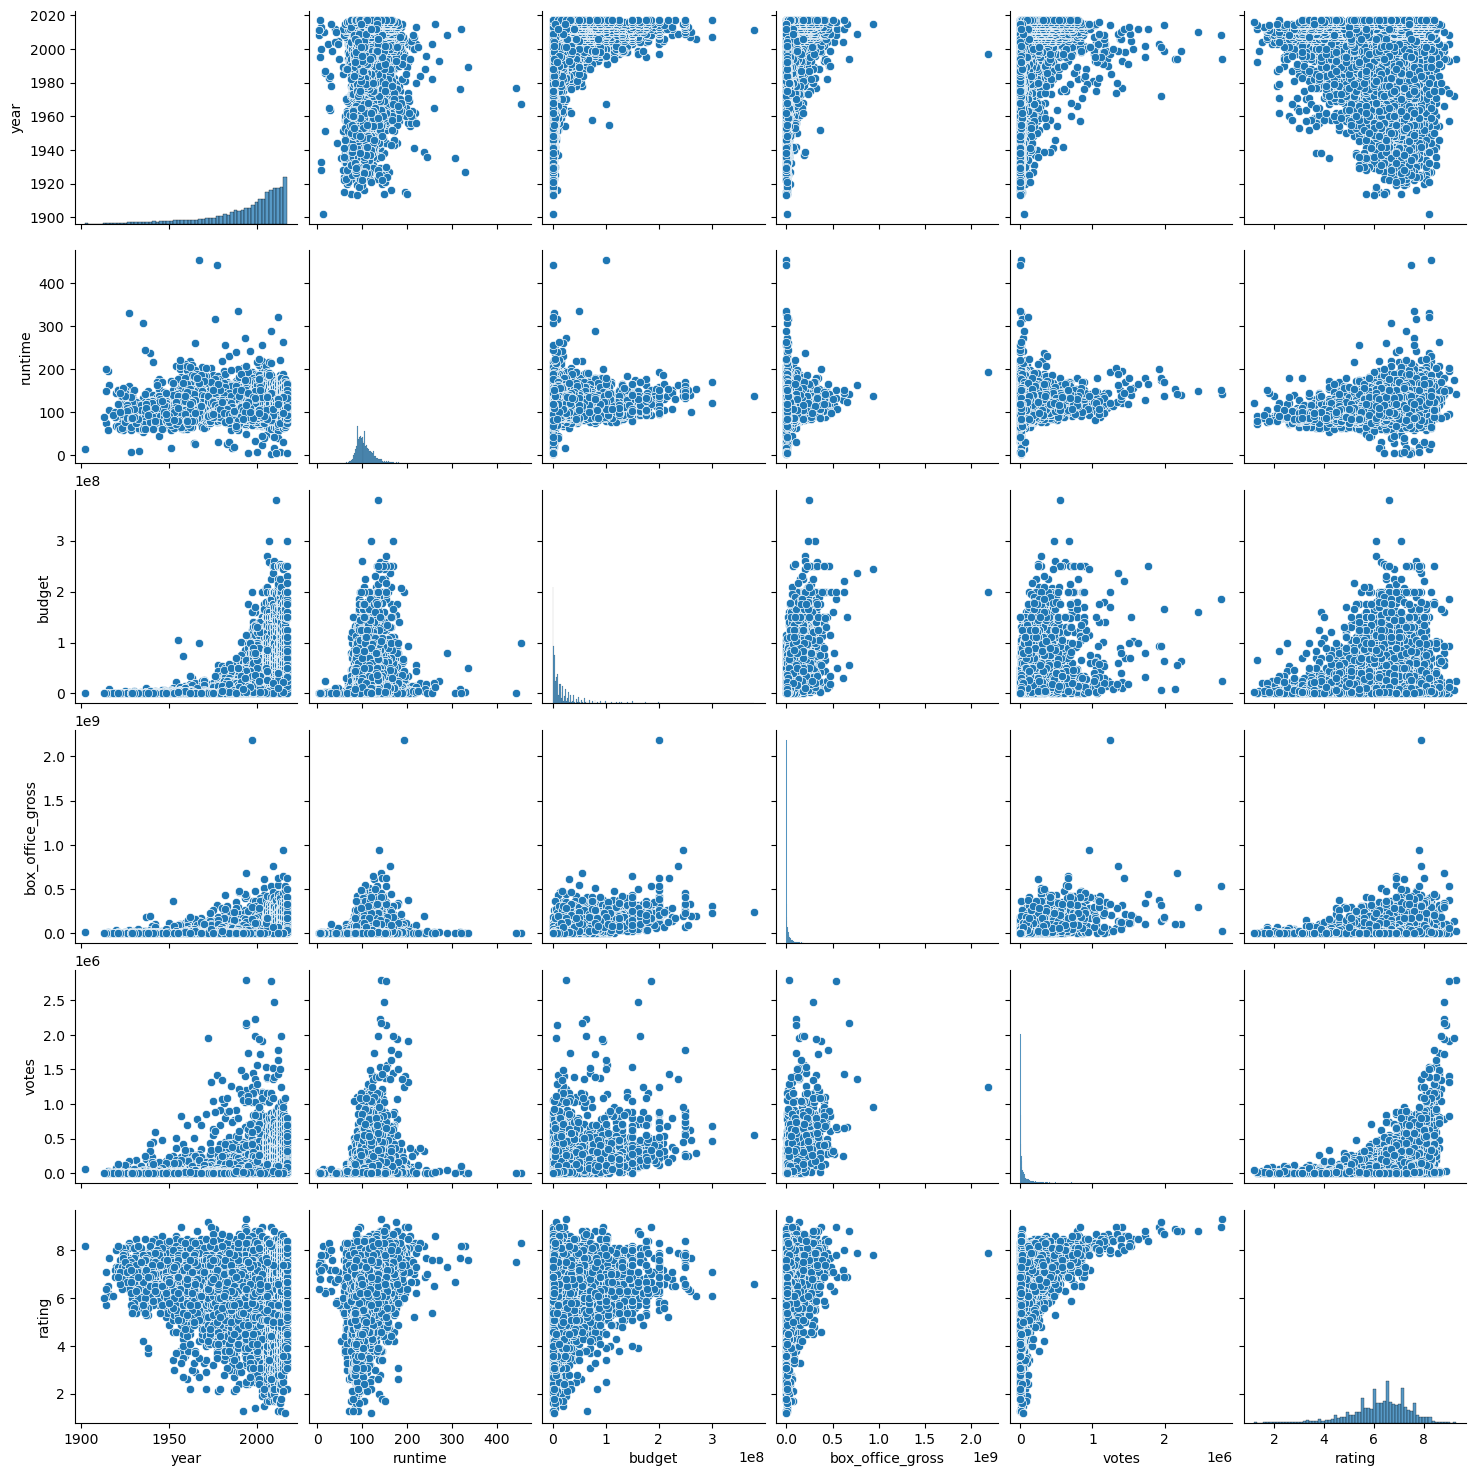

In [16]:
# Pairplot to see relationships between each feature
sns.pairplot(dropna_df[numeric_columns])
plt.show()

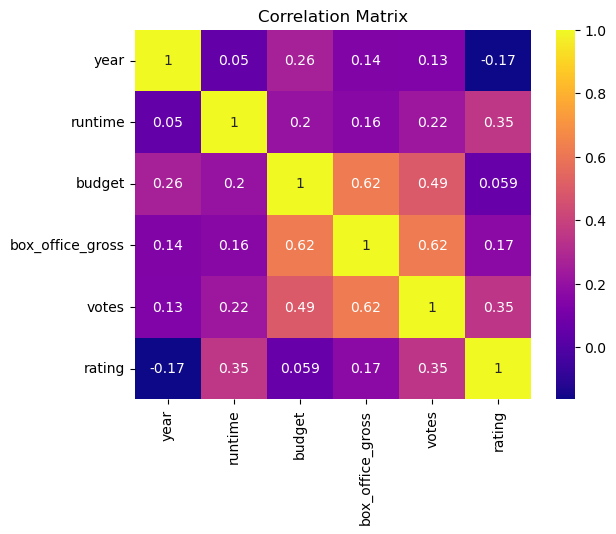

In [17]:
# Create correlation matrix
corr = dropna_df[numeric_columns].corr()

# Plot the heatmap
sns.heatmap(corr, annot=True, cmap='plasma')
plt.title('Correlation Matrix')
plt.show()

We can see there are essentially no linear relationships or strong correlations in our data. This is not totally unexpected, given that we know intuitively that the factors that influence film success are fairly nuanced. Additionally, we are not planning to use any models that heavily rely on linearity and normal distributions. 

#### Creating Rating Bins
Our goal for modeling is to focus on a classification problem. Since our target variable is currently continuous, we need to create different categories and bin the IMDb ratings into those different categories. 

For now we will use quantile binning for classifying the movie ratings into different categories like 'Poor', 'Average', 'Good', and 'Excellent' because it ensures that each category contains roughly the same number of observations. This should help us avoid class imbalance problems, where one category is significantly over- or under-represented compared to others.

By dividing the data into quantiles, we're aiming for a more balanced dataset, in the hopes of creating more generalizable model performance. This can also help capture the inherent variability in the data, since it doesn't rely on arbitrary bin edges, but uses the data's actual distribution to define the bins.

In [18]:
# Create a new column for rating categories based on quantiles
metadata_df['rating_category'] = pd.qcut(metadata_df['rating'], q=4, labels=['Poor', 'Average', 'Good', 'Excellent'])

# Check the distribution across the categories
print(metadata_df['rating_category'].value_counts())

rating_category
Good         13054
Average      12640
Poor         12626
Excellent    11059
Name: count, dtype: int64


In [19]:
# Checking the bounds for each bin 
min_max_ratings = metadata_df.groupby('rating_category')['rating'].agg(['min', 'max'])

print(min_max_ratings)

                 min  max
rating_category          
Poor             1.2  5.5
Average          5.6  6.3
Good             6.4  7.0
Excellent        7.1  9.4


These bins look fairly close to what we would choose just based on common knowledge of and experience with IMDb movie ratings, and they are fairly balanced, so for now quantile binning seems like a good approach.

#### Actors, Directors, Genres, and Production Companies
Let's look to see if there are any significant patterns or observations we can make about the top actors, directors, genres, and production companies. Now that we have binned our ratings, we can also look at these features in relation to the binned ratings.

In [20]:
# Import counter
from collections import Counter

We'll use Counter to count unique numbers of various entities and combinations of entities.

In [21]:
# Flatten the list of actors 
all_actors = [actor for sublist in metadata_df['actors'].tolist() for actor in sublist]

# Convert to set to get unique actors and then count 
unique_actors = set(all_actors)
count_unique_actors = len(unique_actors)

print(f"The number of unique actors is {count_unique_actors}")

The number of unique actors is 74466


In [22]:
# Flatten the list of directors 
all_directors = [director for sublist in metadata_df['directors'].tolist() for director in sublist]

# Convert to set to get unique directors and then count 
unique_directors = set(all_directors)
count_unique_directors = len(unique_directors)

print(f"The number of unique directors is {count_unique_directors}")

The number of unique directors is 20537


In [23]:
# Flatten the list of genres 
all_genres = [genre for sublist in metadata_df['genres'].tolist() for genre in sublist]

# Convert to set to get unique genres and then count 
unique_genres = set(all_genres)
count_unique_genres = len(unique_genres)

print(f"The number of unique genres is {count_unique_genres}")

The number of unique genres is 27


In [24]:
# Flatten the list of production companies 
all_producers = [producer for sublist in metadata_df['production_companies'].tolist() for producer in sublist]

# Convert to set to get unique production companies and then count 
unique_producers = set(all_producers)
count_unique_producers = len(unique_producers)

print(f"The number of unique producers is {count_unique_producers}")

The number of unique producers is 31882


##### Too many unqiue values 

We can see from these counts that there are far too many individual actors, directors, and production companies to one hot encode them. We'll have to decide what sort of feature engineering will be appropriate to capture the values of these categorical columns. We could potentially one hot encode genres since there are only 27, but let's explore the data some more before deciding.

##### Significant Combinations? 
Let's check to see if there are any frequently occurring actor/director combinations in top grosing and highest rated movies.

In [25]:
# Create new dataframe 
combos_df = metadata_df.copy()

In [26]:
# Create a new column that combines the first actor and the first director
combos_df['actor_director_combo'] = combos_df.apply(lambda row: (row['actors'][0] if row['actors'] else 'Unknown', row['directors'][0] if row['directors'] else 'Unknown'), axis=1)

# Filter for top-grossing movies
top_grossing_movies = combos_df.sort_values('box_office_gross', ascending=False).head(100)

# Filter for highest-rated movies
highest_rated_movies = combos_df[combos_df['rating_category'].isin(['Good', 'Excellent'])]

# Count frequent actor-director combinations in top-grossing movies
top_grossing_combos = top_grossing_movies['actor_director_combo'].value_counts()

# Count frequent actor-director combinations in highest-rated movies
highest_rated_combos = highest_rated_movies['actor_director_combo'].value_counts()

# Print out the results
print("Frequent actor-director combinations in top-grossing movies:")
print(top_grossing_combos.head(10))

print("\nFrequent actor-director combinations in highest-rated movies:")
print(highest_rated_combos.head(10))

Frequent actor-director combinations in top-grossing movies:
actor_director_combo
(Daniel Radcliffe,Emma Watson,Rupert Grint,Michael Gambon, David Yates)                 2
(Shia LaBeouf,Megan Fox,Josh Duhamel,Tyrese Gibson, Michael Bay)                        2
(Robert De Niro, Jay Roach)                                                             2
(Elijah Wood,Ian McKellen,Viggo Mortensen,Orlando Bloom, Peter Jackson)                 1
(Chris Pratt,Vin Diesel,Bradley Cooper,Zoe Saldana, James Gunn)                         1
(Rica Matsumoto,Veronica Taylor,Eric Stuart,Ikue Ôtani, Kunihiko Yuyama,Eric Stuart)    1
(Mia Wasikowska,Johnny Depp,Helena Bonham Carter,Anne Hathaway, Tim Burton)             1
(Tom Holland,Michael Keaton,Robert Downey Jr.,Marisa Tomei, Jon Watts)                  1
(Lun Ai,Yuan Chang,Haibao Gao,Li Ma, Yang Song,Chiyu Zhang)                             1
(Sandra Bullock,Jon Hamm,Michael Keaton,Pierre Coffin, Kyle Balda,Pierre Coffin)        1
Name: count, dtype

Let's also check for any frequently occurring director-production company combinations.

In [27]:
# Extract the first director and first production company from each row
top_grossing_director_company = combos_df.apply(lambda x: (x['directors'][0], x['production_companies'][0]) if x['directors'] and x['production_companies'] else None, axis=1)
top_rated_director_company = combos_df.apply(lambda x: (x['directors'][0], x['production_companies'][0]) if x['directors'] and x['production_companies'] else None, axis=1)

# Count the occurrences of each director-production company combination
top_grossing_director_company_counts = top_grossing_director_company.value_counts()
top_rated_director_company_counts = top_rated_director_company.value_counts()

# Display the frequent director-production company combinations
print("Frequent director-production company combinations in top-grossing movies:")
print(top_grossing_director_company_counts.head(10))

print("\nFrequent director-production company combinations in highest-rated movies:")
print(top_rated_director_company_counts.head(10))

Frequent director-production company combinations in top-grossing movies:
(Michael Curtiz, Warner Bros. Pictures)     44
(Richard Thorpe, Metro-Goldwyn-Mayer)       43
(Cheh Chang, Shaw Brothers)                 32
(W.S. Van Dyke, Metro-Goldwyn-Mayer)        30
(Jack Hannah, Walt Disney Productions)      28
(Clarence Brown, Metro-Goldwyn-Mayer)       28
(Henry Hathaway, 20th Century Fox)          28
(William Beaudine, Monogram Pictures)       27
(Jack Conway, Metro-Goldwyn-Mayer)          26
(Robert Z. Leonard, Metro-Goldwyn-Mayer)    26
Name: count, dtype: int64

Frequent director-production company combinations in highest-rated movies:
(Michael Curtiz, Warner Bros. Pictures)     44
(Richard Thorpe, Metro-Goldwyn-Mayer)       43
(Cheh Chang, Shaw Brothers)                 32
(W.S. Van Dyke, Metro-Goldwyn-Mayer)        30
(Jack Hannah, Walt Disney Productions)      28
(Clarence Brown, Metro-Goldwyn-Mayer)       28
(Henry Hathaway, 20th Century Fox)          28
(William Beaudine, Monogr

##### Observations
We can see that there aren't any overwhelmingly frequent actor-director or director-production combinations that stand out in either the top-grossing or the highest-rated movies, at least based on this dataset and the criteria and data we have used for "top-grossing" and "highest-rated." For the top-grossing movies, most of the combinations appear only once or twice. This could mean that the success of a movie (in terms of box office gross) is not heavily dependent on a recurring actor-director team. 

It should be noted that we currently have less than half of the complete data for budget and box office gross. We will try to impute these nubmers later, but won't be able to do so until after we split data into train and test. So for now we're just looking at what we have. We could choose to temporarily use some kind of imputation just for EDA, but for now we'll just look at what we have.

For the highest-rated movies, although some combinations appear more frequently, the numbers are not extraordinarily high either. The combinations also seem to be skewed towards older films or specific niche categories (e.g., Charles Chaplin, Woody Allen), which may not be as relevant to new data. 

Given the nature of the film industry, it's not surprising that there are no overwhelmingly frequent combinations of director and production company, or actor and director, across multiple decades. Actors, directors, and production companies often explore different types of projects and collaborations over their careers, reducing the chance of frequent repeats. The film industry has also evolved over the decades, leading to shifts in popular genres, production styles, and even the structure of production companies.

##### Implications for Feature Engineering

- Given that there are no significantly frequent combinations, this might not be a strong feature to use in a predictive model for box office or ratings. Including them could result in overfitting, if they prevent the model from generalizing well to new data.  

- Even if the combinations are not recurring, the individual actors or directors might still be strong predictors. If certain actors or directors frequently appear in either high-grossing or high-rated movies, those could be useful features. We can explore those more closely now.

##### Plotting Top Cast, Crew, and Production
Next, let's create a function so we can easily extract the cast and crew information, along with the highest box office gross numbers and high ratings. The function will allow us to easily plot the various relatinoships. 

For our function, we will extract the first name in the list for each entity category, because as per IMDb documentation, cast and directors are usually listed in order of "credit" in the official film credits. Thus, we will make the assumption that the first listed actor and director is the most "important". Later we could potentially look at the second name in each list to see if there are any interesting patterns or combinations. We'll look at the top 20 in each category. 

In [28]:
## Define function to get top n cast and crew entities 

def get_top_n_entities(df, column, n=20, sort_by=None, ascending=True):
    """
    Returns the top N most frequent entities in a given column under certain conditions.
    
    df: DataFrame to use
    column: The column name that contains the entities (e.g., 'actors', 'directors', 'production_companies').
    n: Number of top entities to return
    sort_by: Column to sort by before selecting top entities. Default is None.
    ascending: Sorting order. Default is True.
    """
    
    # Sort the DataFrame if sort_by is provided
    if sort_by:
        df = df.sort_values(sort_by, ascending=ascending)
    
    # Extract the first entity from each row
    first_entities = df[column].apply(lambda x: x[0] if x else None)
    
    # Count occurrences of each entity
    entity_counts = first_entities.value_counts()
    
    # Get the top N entities
    top_n_entities = entity_counts.nlargest(n)
    
    return top_n_entities

# Example usage:

## For Directors
# Top 20 directors in highest-grossing movies
top_20_directors_highest_gross = get_top_n_entities(metadata_df, 'directors', sort_by='box_office_gross', ascending=False)

## For Actors
# Top 20 actors in Good and Excellent rated movies
filtered_df = metadata_df[metadata_df['rating_category'].isin(['Good', 'Excellent'])]
top_20_actors_rated = get_top_n_entities(filtered_df, 'actors')

##### Plotting: Frequent Directors
Now, we can use our function to create Pandas series that we can use to plot the values we want.

In [29]:
## TOP DIRECTORS 

# Top 20 directors in highest-grossing movies
top_20_directors_highest_gross = get_top_n_entities(metadata_df, 'directors', sort_by='box_office_gross', ascending=False)

# Top 20 directors in top rated movies 
filtered_df = metadata_df[metadata_df['rating_category'].isin(['Good', 'Excellent'])]
top_20_directors_rated = get_top_n_entities(filtered_df, 'directors')

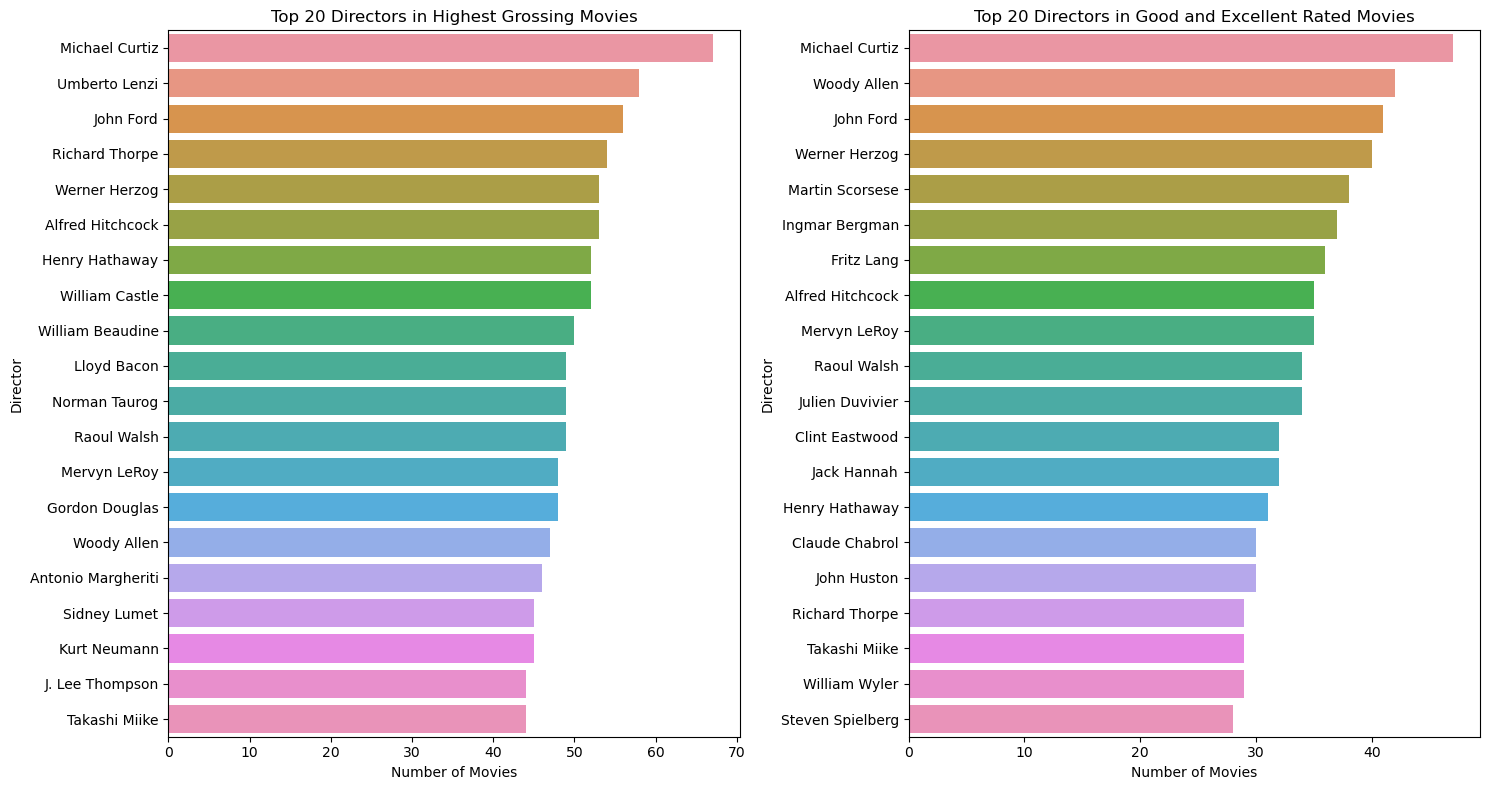

In [30]:
## PLOTTING TOP GROSSING AND HIGHEST RATED DIRECTORS

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot top 20 directors in 'Good' and 'Excellent' rated movies
sns.barplot(y=top_20_directors_highest_gross.index, x=top_20_directors_highest_gross.values, orient='h', ax=axes[0])
axes[0].set_xlabel('Number of Movies')
axes[0].set_ylabel('Director')
axes[0].set_title('Top 20 Directors in Highest Grossing Movies')

# Plot top 20 directors in highest-grossing movies
sns.barplot(y=top_20_directors_rated.index, x=top_20_directors_rated.values, orient='h', ax=axes[1])
axes[1].set_xlabel('Number of Movies')
axes[1].set_ylabel('Director')
axes[1].set_title('Top 20 Directors in Good and Excellent Rated Movies')

plt.tight_layout()
plt.show()

Now let's look at the counts of directors by frequency, regardless of the box office gross or rating, to see how similar the lists are. 

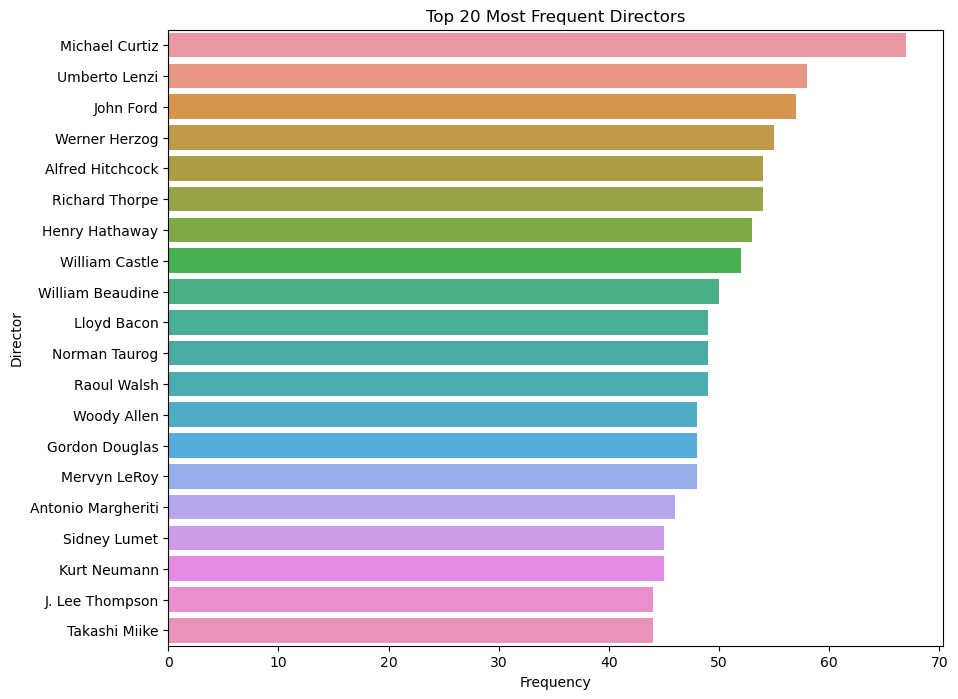

In [31]:
## PLOTTING TOP 20 FREQUENT DIRECTORS

# Flatten the list of directors and count
all_directors = [director for sublist in metadata_df['directors'].tolist() for director in sublist]
director_counts = Counter(all_directors)

# Extract top 30 directors
top_directors = [director for director, _ in director_counts.most_common(20)]
top_director_counts = [count for _, count in director_counts.most_common(20)]

# Create dataframe
df_directors = pd.DataFrame({'Director': top_directors, 'Frequency': top_director_counts})

# Create plot
plt.figure(figsize=(10, 8))
sns.barplot(y='Director', x='Frequency', data=df_directors)
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Directors')
plt.show()

##### Observations: Frequent Directors

There are several directors that are common to all 3 sets of directors. These could potentially be used as predictive features, but again, given the nature of the movie industry, these might not be significant predictors for generalizing to new data with a top count of less than 70 for the most frequent occurence.

##### Plotting: Frequent Actors
Let's plot the 20 most frequently occurring actors in the highest rated and top grossing movies, along with the most frequent across all movies and list positions/cast order.

In [32]:
## TOP ACTORS

# Top 20 actors in highest-grossing movies
top_20_actors_highest_gross = get_top_n_entities(metadata_df, 'actors', sort_by='box_office_gross', ascending=False)

# Top 20 actors in top rated movies 
filtered_df = metadata_df[metadata_df['rating_category'].isin(['Good', 'Excellent'])]
top_20_actors_rated = get_top_n_entities(filtered_df, 'actors')

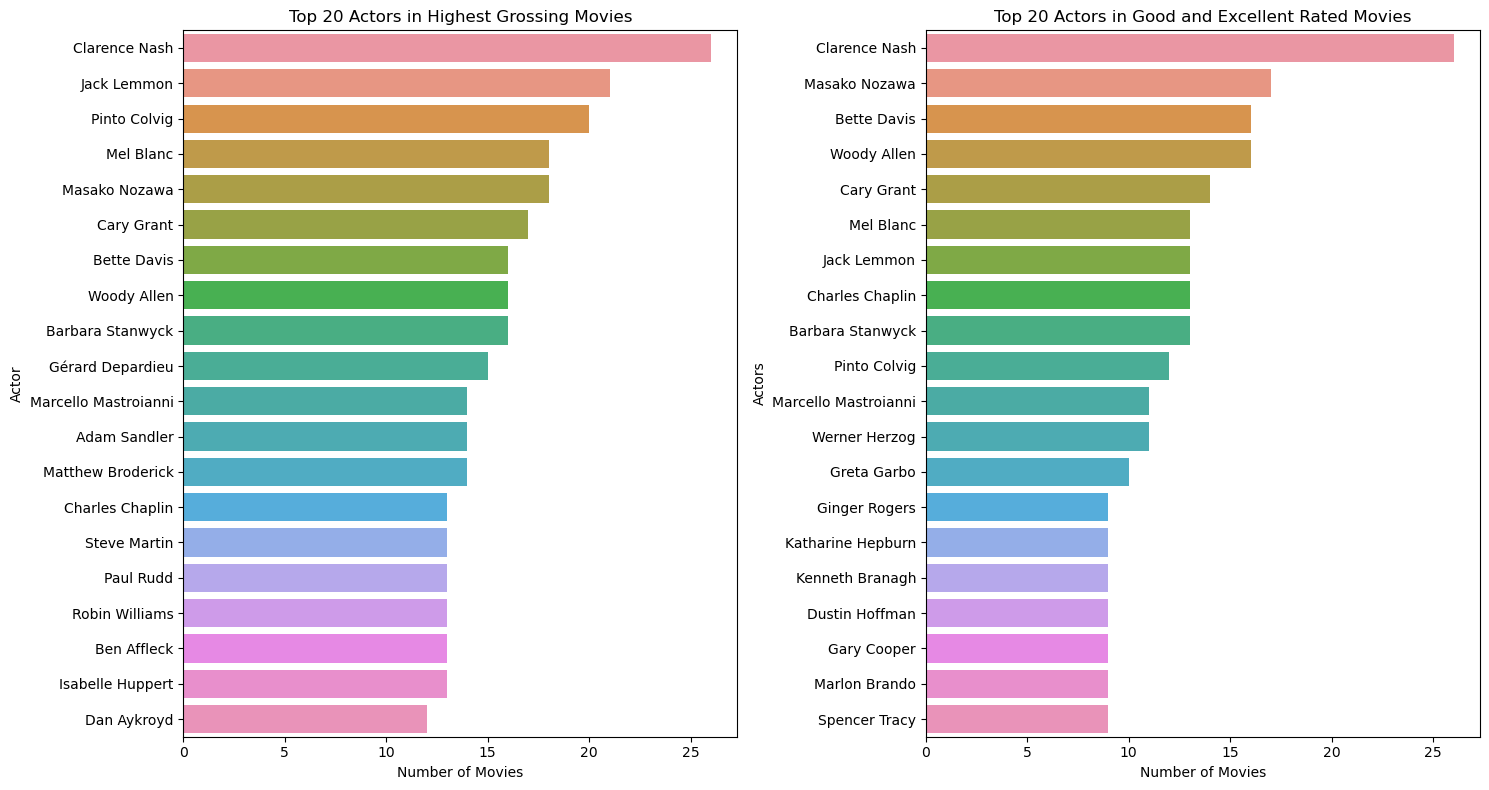

In [33]:
## PLOTTING TOP GROSSING AND HIGHEST RATED ACTORS

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot top 20 actors in 'Good' and 'Excellent' rated movies
sns.barplot(y=top_20_actors_highest_gross.index, x=top_20_actors_highest_gross.values, orient='h', ax=axes[0])
axes[0].set_xlabel('Number of Movies')
axes[0].set_ylabel('Actor')
axes[0].set_title('Top 20 Actors in Highest Grossing Movies')

# Plot top 20 actors in highest-grossing movies
sns.barplot(y=top_20_actors_rated.index, x=top_20_actors_rated.values, orient='h', ax=axes[1])
axes[1].set_xlabel('Number of Movies')
axes[1].set_ylabel('Actors')
axes[1].set_title('Top 20 Actors in Good and Excellent Rated Movies')

plt.tight_layout()
plt.show()

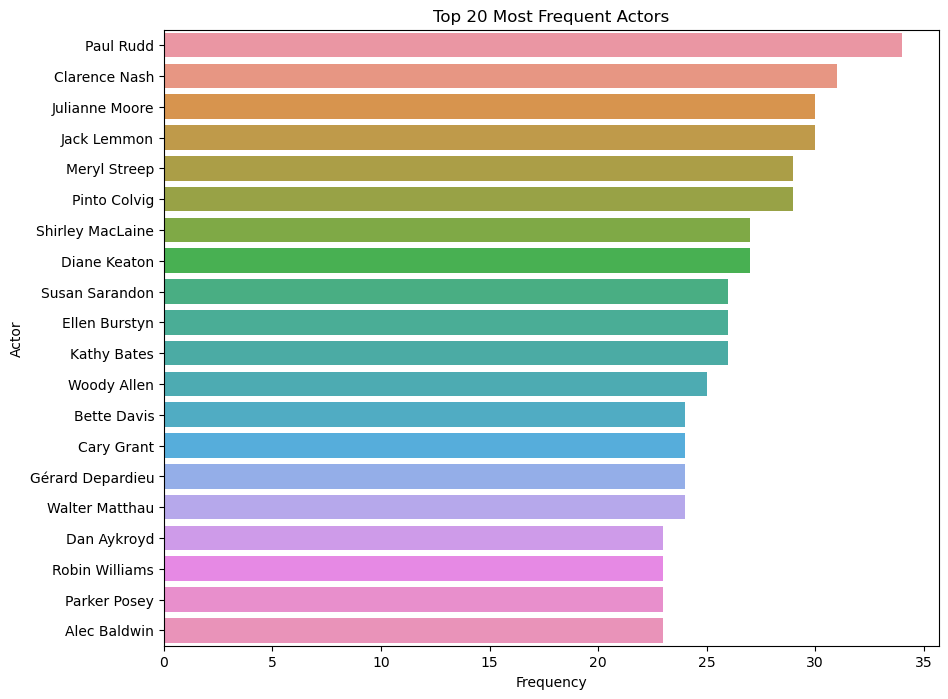

In [34]:
## PLOTTING HIGHEST FREQUENCY ACTORS

# Flatten the list of actors and count 
all_actors = [actor for sublist in metadata_df['actors'].tolist() for actor in sublist]
actor_counts = Counter(all_actors)

# Extract top 20 actors
top_actors = [actor for actor, _ in actor_counts.most_common(20)]
top_actor_counts = [count for _, count in actor_counts.most_common(20)]

# Create dataframe
df_actors = pd.DataFrame({'Actor': top_actors, 'Frequency': top_actor_counts})

# Create the barplot
plt.figure(figsize=(10, 8))
sns.barplot(y='Actor', x='Frequency', data=df_actors)
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Actors')

plt.show()

##### Observations: Frequent Actors

Much like the directors category, there are a few actors that are common to all 3 sets. But again, the frequencies are extremely low when considering the entire dataset, so these likely won't be good canidatates for feature engineering.

##### Plotting: Frequent Production Companies
Let's repeat the same process for production companies now.

In [35]:
## TOP PRODUCTION COMPANIES 

# Top 20 production companies in highest-grossing movies
top_20_companies_highest_gross = get_top_n_entities(metadata_df, 'production_companies', sort_by='box_office_gross', ascending=False)

# Top 20 production companies in top rated movies 
filtered_df = metadata_df[metadata_df['rating_category'].isin(['Good', 'Excellent'])]
top_20_companies_rated = get_top_n_entities(filtered_df, 'production_companies')

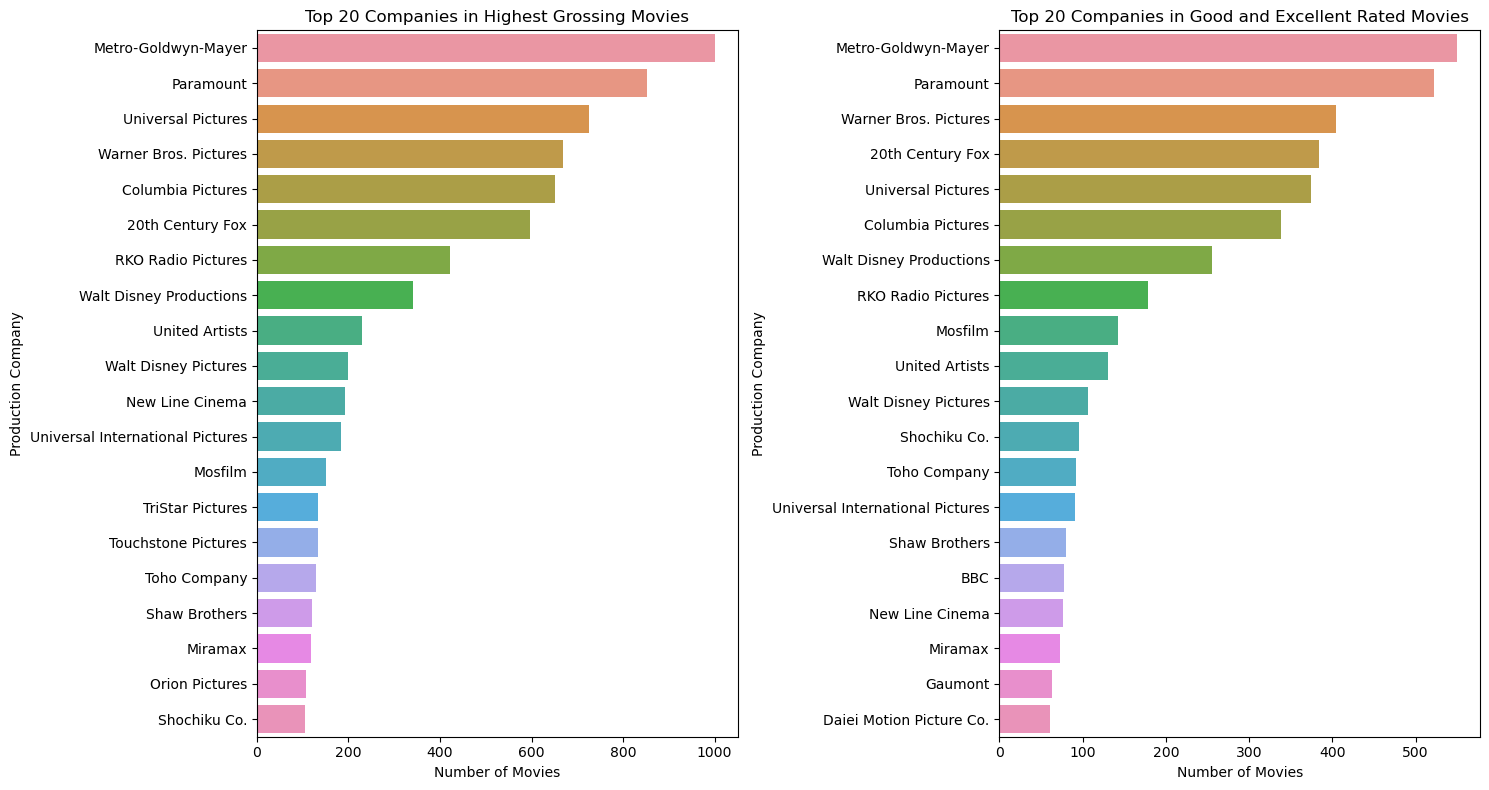

In [36]:
## PLOTTING TOP GROSSING AND HIGHEST RATED PRODUCTION COMPANIES

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot top 20 companies in 'Good' and 'Excellent' rated movies
sns.barplot(y=top_20_companies_highest_gross.index, x=top_20_companies_highest_gross.values, orient='h', ax=axes[0])
axes[0].set_xlabel('Number of Movies')
axes[0].set_ylabel('Production Company')
axes[0].set_title('Top 20 Companies in Highest Grossing Movies')

# Plot top 20 companies in highest-grossing movies
sns.barplot(y=top_20_companies_rated.index, x=top_20_companies_rated.values, orient='h', ax=axes[1])
axes[1].set_xlabel('Number of Movies')
axes[1].set_ylabel('Production Company')
axes[1].set_title('Top 20 Companies in Good and Excellent Rated Movies')

plt.tight_layout()
plt.show()

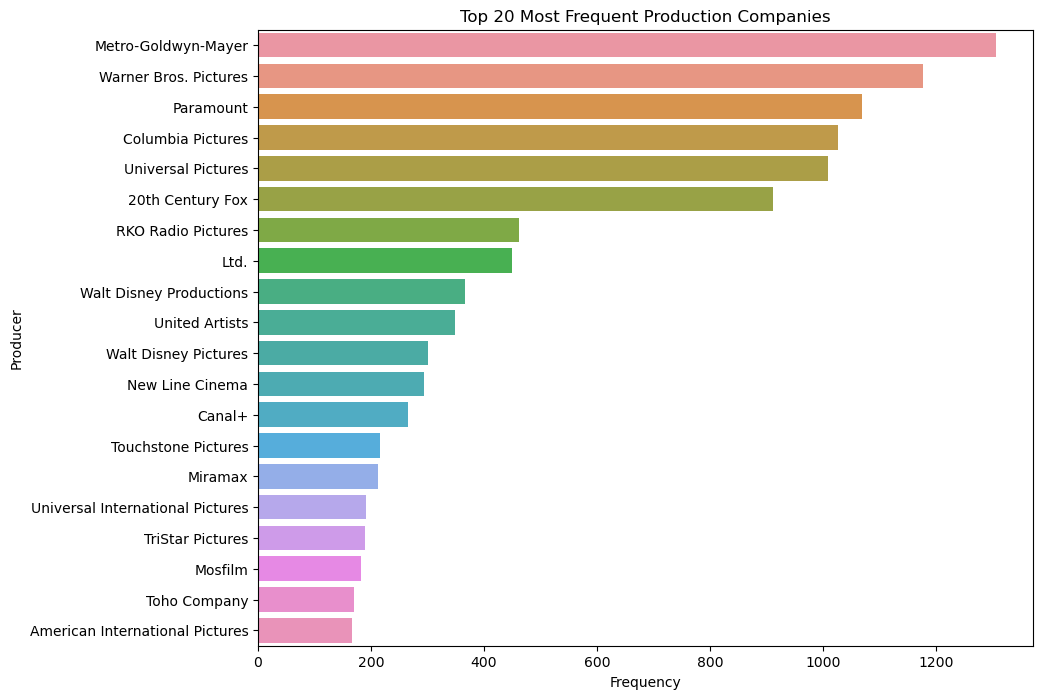

In [38]:
# Flatten the list of production companies and count 
all_producers = [producer for sublist in metadata_df['production_companies'].tolist() for producer in sublist]
producer_counts = Counter(all_producers)

# Extract top 20 producers
top_producers = [producer for producer, _ in producer_counts.most_common(20)]
top_producer_counts = [count for _, count in producer_counts.most_common(20)]

# Create dataframe
df_producer = pd.DataFrame({'Producer': top_producers, 'Frequency': top_producer_counts})

# Create the barplot
plt.figure(figsize=(10, 8))
sns.barplot(y='Producer', x='Frequency', data=df_producer)
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Production Companies')

plt.show()

##### Observations: Frequent Production Companies
The frequencies here are significantly higher than they were for either actors or directors. This makes intuitive sense, given that production companies like MGM and Disney have been in existence for almost the entire timespan of this dataset. We could potentially use something like "big production company" for feature engineering. 

However, we also see some issues: 
1. 'Ltd.' is being counted as a company, likely because we have comma separated lists, and Ltd usually follows a comma in company names. We'll need to solve this, since the frequency is relatively high.

2. There are two different Disney production companies listed. We should examine the moves associated with each and see if this category should be combined. If so, Disney would likely move up the list into the top 5 most frequent production companies. 

We will tackle the Ltd. issue first.

In [39]:
# Create filtered df to deal with Ltd. issue
ltd_df = metadata_df.copy()

In [40]:
# Filter for companies with "Ltd." in the name
ltd_df = metadata_df[metadata_df['production_companies'].apply(lambda x: 'Ltd.' in x )]


# Display the filtered data
ltd_df['production_companies'].head(10)

20                           [Toho Company, Ltd., TBS]
210                               [Shochiku Co., Ltd.]
319    [Teshigahara Productions, Tokyo Eiga Co., Ltd.]
322                               [Shochiku Co., Ltd.]
351                   [Daiei Motion Picture Co., Ltd.]
375      [Toho Company, Ltd., Kurosawa Production Co.]
383                               [Toho Company, Ltd.]
458                [Shochiku Co., Ltd., Bandai Visual]
463                               [Toho Company, Ltd.]
666                               [Shochiku Co., Ltd.]
Name: production_companies, dtype: object

We can define a function to clean up the names. We can remove "Ltd." which will leave us with some empty strings. Then we can remove the empty strings. We'll test it on our filtered dataframe first to make sure it works as expected. 

In [41]:
## Function to remove Ltd. and empty strings from production companies 

def remove_ltd_and_empty_strings(row):
    # Remove 'Ltd.' from each company name
    new_list = [company.replace("Ltd.", "") for company in row]
    
    # Remove any empty strings
    new_list = [company for company in new_list if company != ""]
    
    return new_list

In [42]:
# Apply function to the test dataframe
ltd_df.loc[:, 'production_companies'] = ltd_df['production_companies'].apply(remove_ltd_and_empty_strings)

# Check if it worked
print(ltd_df['production_companies'].head(10))

20                           [Toho Company, TBS]
210                               [Shochiku Co.]
319    [Teshigahara Productions, Tokyo Eiga Co.]
322                               [Shochiku Co.]
351                   [Daiei Motion Picture Co.]
375      [Toho Company, Kurosawa Production Co.]
383                               [Toho Company]
458                [Shochiku Co., Bandai Visual]
463                               [Toho Company]
666                               [Shochiku Co.]
Name: production_companies, dtype: object


Excellent! It looks like this did what we expected. Let's go ahead and apply this to our entire dataframe.

In [43]:
# Apply function to the dataframe
metadata_df.loc[:, 'production_companies'] = metadata_df['production_companies'].apply(remove_ltd_and_empty_strings)

Let's plot again to check that it worked: 

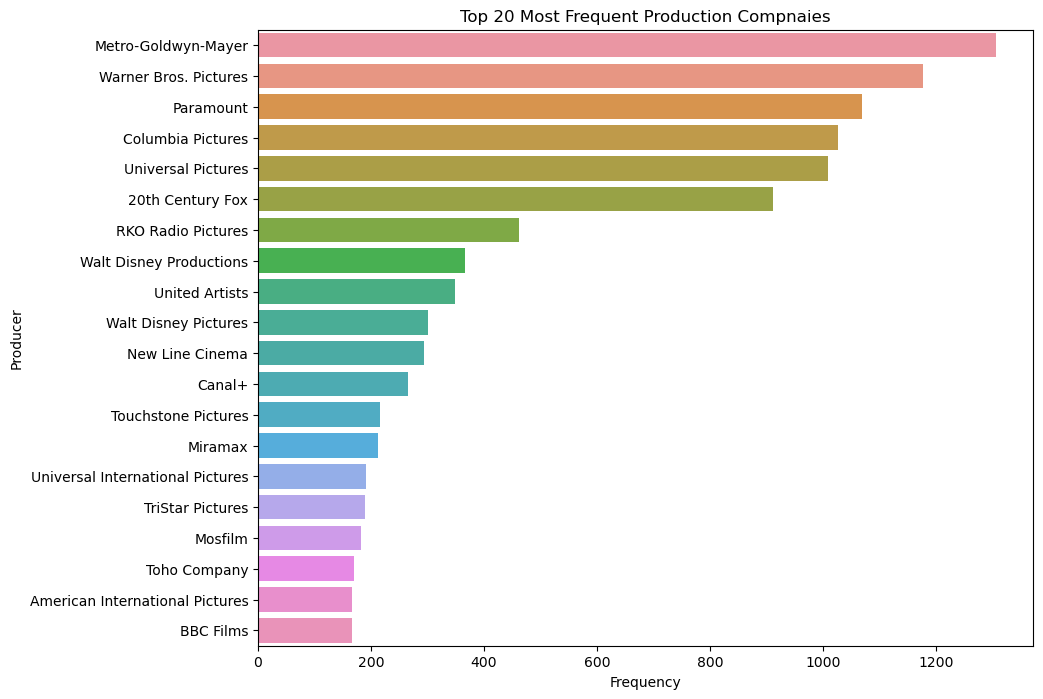

In [44]:
# Flatten the list of production companies and count
all_producers = [producer for sublist in metadata_df['production_companies'].tolist() for producer in sublist]
producer_counts = Counter(all_producers)

# Extract top 20 producers
top_producers = [producer for producer, _ in producer_counts.most_common(20)]
top_producer_counts = [count for _, count in producer_counts.most_common(20)]

# Create dataframe
df_producer = pd.DataFrame({'Producer': top_producers, 'Frequency': top_producer_counts})

# Create the barplot
plt.figure(figsize=(10, 8))
sns.barplot(y='Producer', x='Frequency', data=df_producer)
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Production Compnaies')

plt.show()

Excellent! Ltd. is no longer showing up as a company in our top production companies.

Now, let's look at fixing the Disney issue. We'll create a filtered dataframe to test on. We can see that there are 3 different variations of Disney, so we'll filter based on that.

In [45]:
# Filter the dataframe for Disney companies
disney_df = metadata_df[metadata_df['production_companies'].apply(lambda x: 'Walt Disney Pictures' in x or 'Walt Disney Productions' in x or 'Walt Disney Animation Studios' in x)]

# Display the filtered dataframe
disney_df.head(10)

,imdb_id,title,actors,directors,genres,language_en,year,runtime,budget,box_office_gross,production_companies,votes,rating,rating_category
93,tt0198781,"Monsters, Inc.","[Billy Crystal,John Goodman,Mary Gibbs,Steve B...","[Pete Docter,David Silverman,Lee Unkrich]","[Animation, Adventure, Comedy]",1,2001,92,115000000.0,289916256.0,"[Pixar, Walt Disney Pictures]",949001,8.1,Excellent
157,tt0368891,National Treasure,"[Nicolas Cage,Diane Kruger,Justin Bartha,Sean ...",[Jon Turteltaub],"[Action, Adventure, Mystery]",1,2004,131,100000000.0,173008894.0,"[Walt Disney Pictures, Jerry Bruckheimer Films...",346876,6.9,Good
163,tt0029583,Snow White and the Seven Dwarfs,"[Adriana Caselotti,Harry Stockwell,Lucille La ...","[William Cottrell,David Hand,Wilfred Jackson,L...","[Animation, Adventure, Family]",1,1937,83,1488423.0,184925485.0,[Walt Disney Productions],209772,7.6,Excellent
167,tt0120917,The Emperor's New Groove,"[David Spade,John Goodman,Eartha Kitt,Patrick ...",[Mark Dindal],"[Animation, Adventure, Comedy]",1,2000,78,100000000.0,89302687.0,"[Walt Disney Animation Studios, Walt Disney Pi...",217182,7.4,Excellent
199,tt0325980,Pirates of the Caribbean: The Curse of the Bla...,"[Johnny Depp,Geoffrey Rush,Orlando Bloom,Keira...",[Gore Verbinski],"[Action, Adventure, Fantasy]",1,2003,143,140000000.0,305413918.0,"[Walt Disney Pictures, Jerry Bruckheimer Films]",1173773,8.1,Excellent
382,tt0131620,Tower of Terror,"[Steve Guttenberg,Kirsten Dunst,Nia Peeples,Mi...",[D.J. MacHale],"[Adventure, Comedy, Drama]",1,1997,89,NaN,NaN,[Walt Disney Pictures],3987,6.1,Average
613,tt0317705,The Incredibles,"[Craig T. Nelson,Samuel L. Jackson,Holly Hunte...",[Brad Bird],"[Animation, Action, Adventure]",1,2004,115,92000000.0,261441092.0,"[Pixar, Walt Disney Pictures]",778613,8.0,Excellent
720,tt0058331,Mary Poppins,"[Julie Andrews,Dick Van Dyke,David Tomlinson,G...",[Robert Stevenson],"[Comedy, Family, Fantasy]",1,1964,139,6000000.0,102272727.0,"[Walt Disney Productions, Walt Disney Pictures]",180697,7.8,Excellent
940,tt0114148,Pocahontas,"[Mel Gibson,Linda Hunt,Christian Bale,Joe Baker]","[Mike Gabriel,Eric Goldberg]","[Animation, Adventure, Drama]",1,1995,81,55000000.0,141600000.0,"[Walt Disney Animation Studios, Walt Disney Pi...",197380,6.7,Good
1088,tt0097757,The Little Mermaid,"[Jodi Benson,Samuel E. Wright,Rene Auberjonois...","[Ron Clements,John Musker]","[Animation, Adventure, Family]",1,1989,83,40000000.0,111543479.0,"[Walt Disney Pictures, Silver Screen Partners IV]",282767,7.6,Excellent


Let's check the ratings and counts of Walt Disney Animation Studios.

In [46]:
# Filter DataFrame for rows containing Walt Disney Animation Studios
disney_animation_df = disney_df[disney_df['production_companies'].apply(lambda x: 'Walt Disney Animation Studios' in x if x is not None else False)]

# Get the count of each rating category
rating_count = disney_animation_df['rating_category'].value_counts()

print(rating_count)

rating_category
Excellent    29
Good          9
Average       4
Poor          1
Name: count, dtype: int64


After looking at a large sample of movies wtih the different variations of 'Disney' (truncated here for easier reading), it seems like it makes sense to combine Walt Disney Productions and Walt Disney Pictures into one company. The main difference between two of the names seems to be related to the time period, as Disney Productions was incorporated in the 80s to encompass the live actition division of Disney. Additionally, the fact that both of these companies were relatively close on the list of top 20 companies reinforces the decision to combine them. Additionally, we'll combine Walt Disney Animation Studios under the Disney umbrella, since there are so few of them, the majority are top rated, and the genre feature can capture any nuances related specifically to anitmated vs live action movies. 

In [47]:
# Define function to combine Disney entities
def combine_disney(companies):
    if companies is None:
        return None
    new_companies = ['Walt Disney Pictures' if 'Disney' in company else company for company in companies]
    new_companies = list(set(new_companies))  # Remove duplicates
    return new_companies

In [48]:
# Apply the function to the filtered disney_df
disney_df.loc[:, 'production_companies'] = disney_df['production_companies'].apply(combine_disney)

In [49]:
disney_df.sample(10)

,imdb_id,title,actors,directors,genres,language_en,year,runtime,budget,box_office_gross,production_companies,votes,rating,rating_category
13039,tt0066811,The Barefoot Executive,"[Wally Cox, Joe Flynn, Harry Morgan, Kurt Russ...",[Robert Butler],"[Comedy, Family]",1,1971,96,NaN,NaN,[Walt Disney Pictures],2013,5.9,Average
13177,tt0240684,The Little Mermaid II: Return to the Sea,"[Tara Strong,Pat Carroll,Jodi Benson,Samuel E....","[Jim Kammerud,Brian Smith,Bill Speers]","[Animation, Adventure, Comedy]",1,2000,75,NaN,24477615.0,[Walt Disney Pictures],21512,5.5,Poor
22282,tt0071288,The Castaway Cowboy,"[James Garner,Vera Miles,Robert Culp,Eric Shea]",[Vincent McEveety],"[Comedy, Family, Western]",0,1974,91,NaN,2640000.0,[Walt Disney Pictures],844,5.8,Average
7360,tt0110006,Heavyweights,"[Tom McGowan,Aaron Schwartz,Ben Stiller,David ...",[Steven Brill],"[Comedy, Drama, Family]",1,1995,100,10000000.0,17689177.0,"[Walt Disney Pictures, Caravan Pictures]",29827,6.6,Good
48915,tt0226796,I'm No Fool with a Bicycle,[Cliff Edwards],"[Bill Justice,Cliff Edwards]","[Animation, Family, Short]",1,1956,8,NaN,NaN,[Walt Disney Pictures],83,6.8,Good
18018,tt0033671,A Good Time for a Dime,[Clarence Nash],"[Jack King,Dick Lundy,Clarence Nash]","[Family, Animation, Comedy]",1,1941,8,NaN,NaN,[Walt Disney Pictures],640,6.8,Good
382,tt0131620,Tower of Terror,"[Steve Guttenberg,Kirsten Dunst,Nia Peeples,Mi...",[D.J. MacHale],"[Adventure, Comedy, Drama]",1,1997,89,NaN,NaN,[Walt Disney Pictures],3987,6.1,Average
15528,tt0057546,The Sword in the Stone,"[Rickie Sorensen,Sebastian Cabot,Karl Swenson,...","[Wolfgang Reitherman,Clyde Geronimi,David Hand]","[Animation, Adventure, Comedy]",0,1963,79,3000000.0,22182353.0,[Walt Disney Pictures],103521,7.1,Excellent
12478,tt0119432,Jungle 2 Jungle,"[Tim Allen, Martin Short, JoBeth Williams, Lol...",[John Pasquin],"[Comedy, Family]",1,1997,97,32000000.0,59927618.0,"[Walt Disney Pictures, TF1 Films Production]",25399,5.2,Poor
14115,tt0055232,"Nikki, Wild Dog of the North","[Jean Coutu,Émile Genest,Uriel Luft,Robert Riv...","[Jack Couffer,Don Haldane]","[Adventure, Family]",1,1961,74,NaN,NaN,"[Westminster Films, Cangary, Walt Disney Pictu...",496,6.7,Good


Great, it looks like this did what we expected, so let's apply it to the whole dataframe.

In [50]:
# Applying the function to the whole dataframe 
metadata_df.loc[:, 'production_companies'] = metadata_df['production_companies'].apply(combine_disney)

Let's plot the top companies once again:

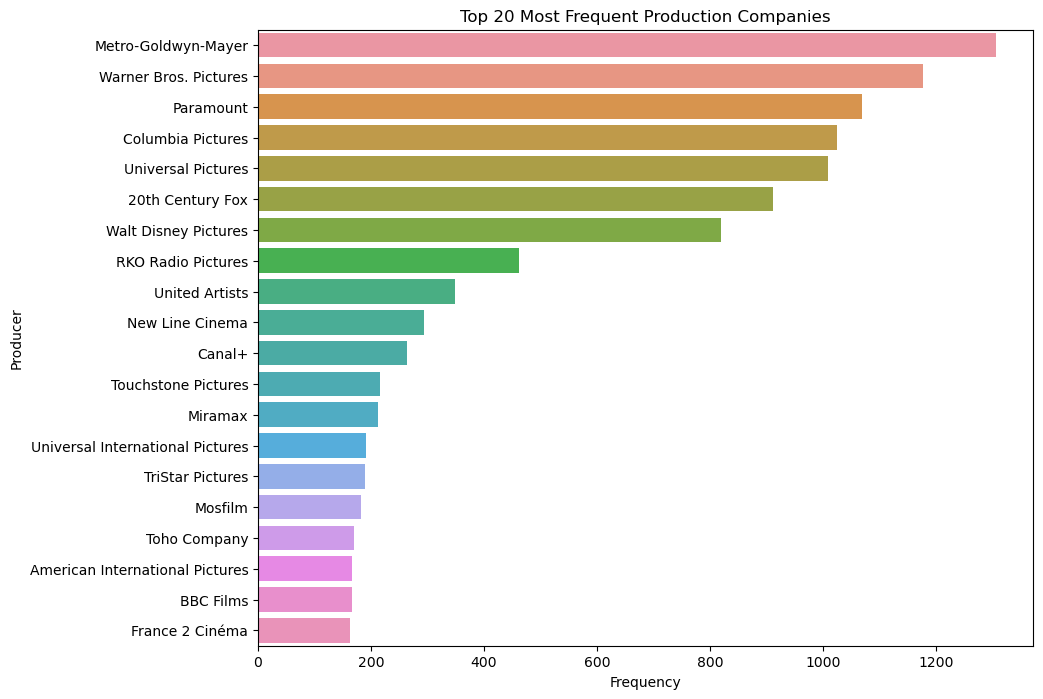

In [52]:
# Flatten the list of production companies and count
all_producers = [producer for sublist in metadata_df['production_companies'].tolist() for producer in sublist]
producer_counts = Counter(all_producers)

# Extract top 20 producers
top_producers = [producer for producer, _ in producer_counts.most_common(20)]
top_producer_counts = [count for _, count in producer_counts.most_common(20)]

# Create dataframe
df_producer = pd.DataFrame({'Producer': top_producers, 'Frequency': top_producer_counts})

# Create the barplot
plt.figure(figsize=(10, 8))
sns.barplot(y='Producer', x='Frequency', data=df_producer)
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Production Companies')

plt.show()

##### Final Observations: Frequent Production Companies

The higher frequencies for production companies in both high-rated and top-grossing movies suggest that this feature might be more useful for predictive modeling compared to actor-director combinations.

- **Industry Influence:** Production companies often play a significant role in a movie's success, from the selection of the script to marketing and distribution. Their influence could be a useful predictive feature.

- **Data Density:** With frequencies in the hundreds to thousands, the feature can provide a more balanced and less sparse input for modeling.

- **Categorical Encoding:** We might consider one-hot encoding these companies or perhaps using target encoding, by replacing the company name with the average success rate of movies from that company.

It could also be useful to explore interaction between production companies and other features like genre, budget, or decade, to capture the nuanced impact they may have.

#### Final Thoughts on Actors, Directors, and Production Companies 
We haven't discovered any extremely obvious insights from what we've looked at for these features, and there are too many unique entities to one hot encode. Thus, for feature engineering, we'll go with a "top-N" approach. Since we're using this feature to predict movie ratings, starting with a rating-based approach makes the most sense. After we establish a baseline model, perhaps we can experiment with different ways of defining "top N" to see if it improves the model's performance.

For now, let's go with getting the top 10 entities from each category, and then one hot encoding them. 

##### Top Grossing and High-Rated Genres
Now, let's take a look at the genres in much the same way that we have for the cast, crew, and production companies. However, unlike the cast and crew, as per IMDb documentation, genres are listed alphabetically, and not in any particular order. So we'll modify the function we used earlier to look at *all* list items, rather than extracting the first item from each list.

In [53]:
## Define new funtion to count all list items to get top entities

def get_all_top_n_entities(df, column, n=20, sort_by=None, ascending=True):
    """
    Returns the top N most frequent entities in a given column under certain conditions.
    
    df: DataFrame to use
    column: The column name that contains the entities (e.g., 'actors', 'directors', 'production_companies').
    n: Number of top entities to return
    sort_by: Column to sort by before selecting top entities. Default is None.
    ascending: Sorting order. Default is True.
    """
    
    # Sort the DataFrame if sort_by is provided
    if sort_by:
        df = df.sort_values(sort_by, ascending=ascending)
        
    # Flatten the list of lists into a single list
    all_entities = [entity for sublist in df[column].dropna() for entity in sublist]
    
    # Count occurrences of each entity
    entity_counts = Counter(all_entities)
    
    # Convert to DataFrame for easy sorting and selecting top N
    entity_counts_df = pd.DataFrame.from_dict(entity_counts, orient='index', columns=['Count']).reset_index()
    entity_counts_df = entity_counts_df.rename(columns={"index": "Entity"})
    
    # Sort and get top N entities
    entity_counts_df = entity_counts_df.sort_values('Count', ascending=False).head(n)
    
    return entity_counts_df

# Example usage:
# top_20_genres = get_top_n_entities(df, 'genre')

Creating variables for top genres for plotting.

In [54]:
## TOP GENRES

# Top 20 genres in highest-grossing movies
top_20_genres_highest_gross = get_all_top_n_entities(metadata_df, 'genres', sort_by='box_office_gross', ascending=False)

# Top 20 genres in top rated movies
filtered_df = metadata_df[metadata_df['rating_category'].isin(['Good', 'Excellent'])]
top_20_genres_rated = get_all_top_n_entities(filtered_df, 'genres')

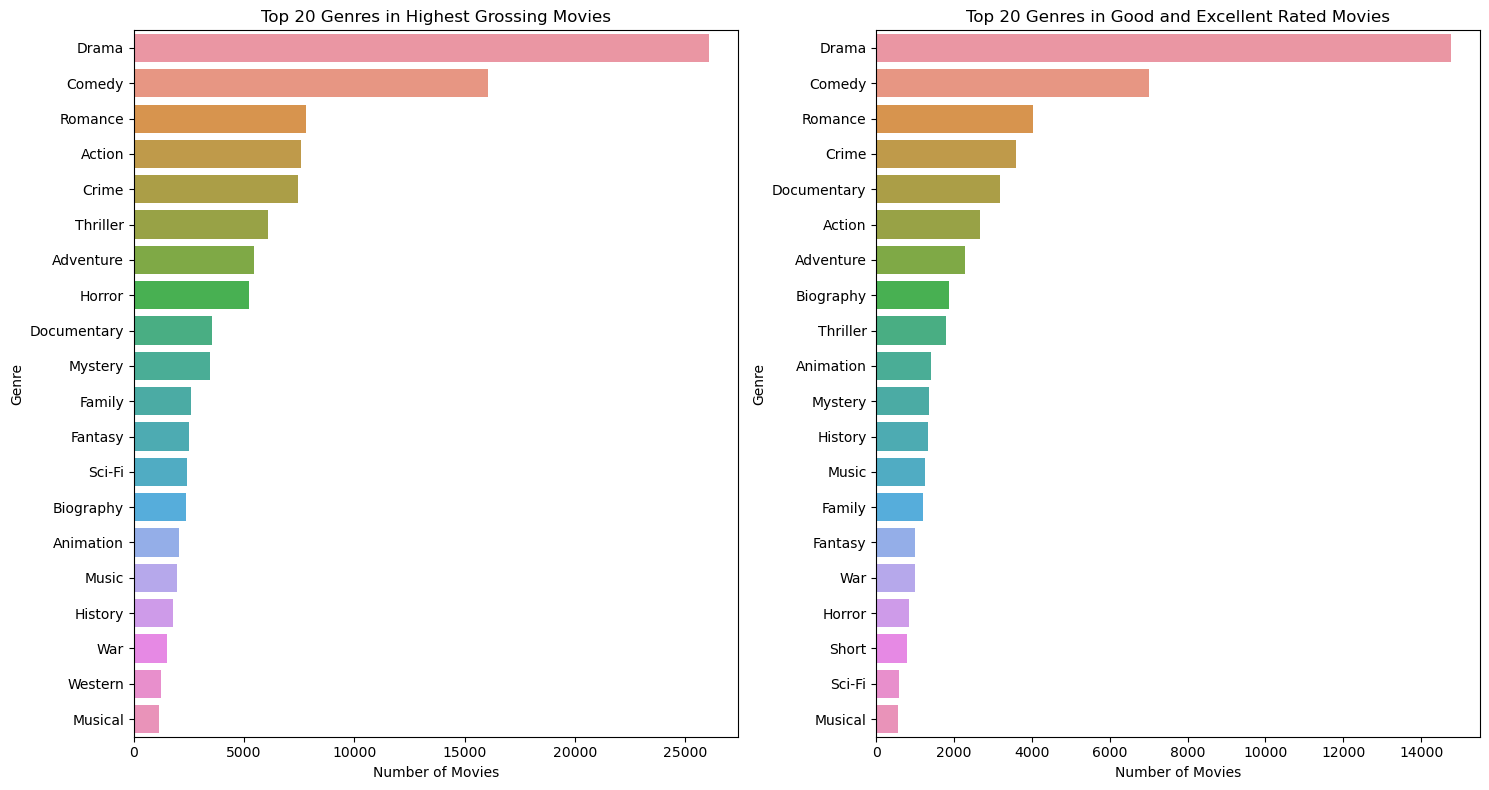

In [55]:
## PLOTTING TOP GROSSING AND HIGHEST RATED GENRES

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot for top 20 genres in highest-grossing movies
sns.barplot(y='Entity', x='Count', data=top_20_genres_highest_gross, orient='h', ax=axes[0])
axes[0].set_xlabel('Number of Movies')
axes[0].set_ylabel('Genre')
axes[0].set_title('Top 20 Genres in Highest Grossing Movies')

# Plot for top_20_genres_rated:
sns.barplot(y='Entity', x='Count', data=top_20_genres_rated, orient='h', ax=axes[1])
axes[1].set_xlabel('Number of Movies')
axes[1].set_ylabel('Genre')
axes[1].set_title('Top 20 Genres in Good and Excellent Rated Movies')

plt.tight_layout()
plt.show()

Now, let's look at frequent genres, disregarding rating and gross.

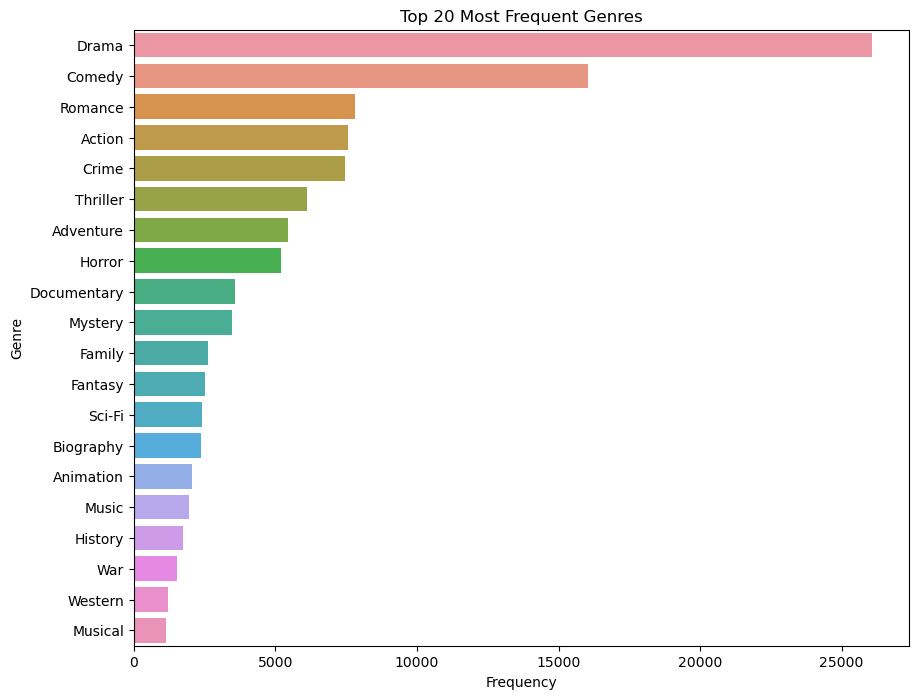

In [56]:
# Flatten the list of genres and count
all_genres = [genre for sublist in metadata_df['genres'].tolist() for genre in sublist]
genre_counts = Counter(all_genres)

# Extract top 20 genres
top_genres = [genre for genre, _ in genre_counts.most_common(20)]
top_genre_counts = [count for _, count in genre_counts.most_common(20)]

# Create dataframe
df_genre = pd.DataFrame({'Genre': top_genres, 'Frequency': top_genre_counts})

# Create  barplot
plt.figure(figsize=(10, 8))
sns.barplot(y='Genre', x='Frequency', data=df_genre)
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Genres')

plt.show()

##### Observations: Frequent Genres 
The genres across all 3 sets are very similar. Drama is by far the predominant genre across all groups.

Given what we know about the genres, i.e. that they are in alphabetical order, we need to make a decision about how to encode them. Alphabetical order is not a meaningful order in terms of the movie's characteristics, so it's not informative to only consider the first genre in the list.

Since there are only 27 genres, one-hot encoding them would add a reasonable amount of features to our dataset. This way, all genres associated with a movie would be equally considered, without any one genre being unfairly emphasized because of its alphabetical precedence. This will allow the model to understand each genre's individual contribution to the movie's rating.

#### Decades

When thinking about how to handle the year feature for this dataset, we have to decide if it makes sense to treat it as a numerical or categorical variable. Since we've already seen that the relationship is not linear, it probably makes sense to treat it as categorical, which will remove the assumption of a linear relationship an dmaybe allow the model to capture more complex interactions between year and rating. At least for our baseline model. Additionally, grouping the years into decades may reveal more general trends or patterns that could be more easily interpretable. 

In [57]:
# Create a new column 'decade' by taking floor division of each year by 10 and then multiplying by 10
metadata_df['decade'] = (metadata_df['year'] // 10) * 10

In [58]:
# Check
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49379 entries, 0 to 49378
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   imdb_id               49379 non-null  object  
 1   title                 49379 non-null  object  
 2   actors                49379 non-null  object  
 3   directors             49379 non-null  object  
 4   genres                49379 non-null  object  
 5   language_en           49379 non-null  int64   
 6   year                  49379 non-null  int64   
 7   runtime               49379 non-null  int64   
 8   budget                17818 non-null  float64 
 9   box_office_gross      21049 non-null  float64 
 10  production_companies  49379 non-null  object  
 11  votes                 49379 non-null  int64   
 12  rating                49379 non-null  float64 
 13  rating_category       49379 non-null  category
 14  decade                49379 non-null  int64   
dtypes:

In [59]:
# Check decade distribution
metadata_df['decade'].value_counts()

decade
2010    12581
2000    11331
1990     6069
1980     4418
1970     4396
1960     3208
1950     2824
1940     2167
1930     1927
1920      375
1910       80
1900        3
Name: count, dtype: int64

#### Feature Engineering Task List
To summarize the decisioncs we've made regarding feature engineering: 
- Bin Ratings into categories using quantiles 
    - Drop `ratings` feature 
- Bin `year` into decades 
    - Drop `year` feature
- For `actors`, `directors`, and `production_companies`, gather top 10 and one hot encode 
    - Drop original columns 
- For `genres`, explode out into columns and one hot encode to retain all genre information 
- Drop `title` 
- Keep `votes`, `budget`, and `box_office_gross` as integers 
- Keep `runtime` as integer 


### Moving on to Text Data

Let's now turn to our review text data and do some preliminary EDA on that, so we can make informed decisions about how to preprocess the text data for modeling. Let's do some basic checks before doing any analysis. We can also drop the `language` column, since it was temporary and just needed to confirm all our reviews were in English.

In [68]:
# Drop language column
reviews_df = reviews_df.drop(columns=['language'])

Let's double check again that we don't have any duplicate reviews.

In [61]:
# Check for duplicates
reviews_df.duplicated().sum()

0

Let's still do a more thorough check for duplicates.

In [62]:
# Count the total number of reviews
total_reviews = len(reviews_df)

print(f"Total number of reviews: {total_reviews}")

Total number of reviews: 3147256


In [63]:
# Count the number of unique reviews
unique_reviews = reviews_df['review_text'].nunique()

print(f"Number of unique reviews: {unique_reviews}")

Number of unique reviews: 3146778


In [64]:
# Check for duplicates only in review text column
reviews_df['review_text'].duplicated().sum()

478

Hmm, it seems we have some duplciate reviews, but only when we search by the review text column. Let's take a closer look at those.

In [65]:
# Find duplicate reviews
duplicate_reviews_df = reviews_df[reviews_df.duplicated(subset=['review_text'], keep=False)]

# Sort by 'review_text' to see duplicates next to each other
duplicate_reviews_df = duplicate_reviews_df.sort_values('review_text')

# Display duplicates
duplicate_reviews_df.head(20)

,imdb_id,review_text
2748973,tt1077368,"""Over the years all these vampire movies have ..."
3066882,tt0103874,"""Over the years all these vampire movies have ..."
962149,tt0090756,"""So Who Won?"" (Not a Spoiler); Ethan & Joel Co..."
801835,tt0086979,"""So Who Won?"" (Not a Spoiler); Ethan & Joel Co..."
869621,tt0019254,"""The Passion of Joan of Arc"" vs ""The Trial of ..."
869619,tt0059616,"""The Passion of Joan of Arc"" vs ""The Trial of ..."
1376702,tt1077368,"""nobody looks like a vampire anymore"".....; ""O..."
1376698,tt0021814,"""nobody looks like a vampire anymore"".....; ""O..."
2824707,tt1211837,". . . (which comes AFTER ""all"" the closing cre..."
2608720,tt0076759,". . . (which comes AFTER ""all"" the closing cre..."


After examining the movie IDs for these duplicate reviews, it seems that they are for very similar movies *(e.g. two different Dracula movies, or part 1 and part 2 of a series)*, and likely our original dataset had some mislabled data. We will drop all of these rows since there is not a reliable way for us to determine exactly which movie the reviewer was referencing, and because we have a lot of data for review text.

In [66]:
# Drop rows where 'review_text' is duplicated
reviews_df.drop_duplicates(subset=['review_text'], keep=False, inplace=True)

In [67]:
# Check unique number of imdb_ids after dropping duplicates
unique_imdb_ids = reviews_df['imdb_id'].nunique()
print(f"Number of unique imdb_id: {unique_imdb_ids}")

Number of unique imdb_id: 49378


It looks like we've lost one unique `imdb_id` after dropping the review text, not bad. This will be reflected when we merge our dataframes later.

Next, we will add temporary `rating` and `rating_category` columns to our reviews dataframe so that we can gather insights about review text as it relates to movie rating. We'll add these columns and then start with some basic statistics.

In [68]:
# Adding the temporary rating column to the reviews dataframe
reviews_df = pd.merge(reviews_df, metadata_df[['imdb_id', 'rating']], on='imdb_id', how='left')

In [69]:
# Adding the temporary rating_category column to the reviews dataframe
reviews_df = pd.merge(reviews_df, metadata_df[['imdb_id', 'rating_category']], on='imdb_id', how='left')

In [70]:
# Check 
reviews_df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3146437 entries, 0 to 3146436
Data columns (total 4 columns):
 #   Column           Dtype   
---  ------           -----   
 0   imdb_id          object  
 1   review_text      object  
 2   rating           float64 
 3   rating_category  category
dtypes: category(1), float64(1), object(2)
memory usage: 75.0+ MB


In [71]:
# Check for null values
reviews_df['rating'].isna().sum()

0

Great! Now we have our temproary columns so there is a movie rating associated with each review. Let's proceed with looking at some basic stats about our corpus of review text.

In [72]:
# Calculate the average review length
reviews_df['review_length'] = reviews_df['review_text'].apply(lambda x: len(str(x).split()))
average_length = round(reviews_df['review_length'].mean(),0)

print(f"Average review length: {average_length} words")

Average review length: 259.0 words


In [73]:
# Group by ratings to get some insights
grouped_by_rating = reviews_df.groupby('rating_category').agg({'review_length': ['mean', 'median', 'std', 'min', 'max']}).reset_index()

In [74]:
# Display ratings
grouped_by_rating

rating_category review_length                             
                           mean median         std min   max
0            Poor    242.618105  184.0  172.217539   4  2070
1         Average    253.597301  192.0  181.461921   6  2829
2            Good    259.594941  195.0  187.673126   3  3013
3       Excellent    267.032253  197.0  198.175622   1  3880

Interesting! The differences between means and medians are not very large across categories. The means are all in the 240-270 character range, and the medians are even closer, ranging from 184 to 197 characters. The standard deviations also suggest that the lengths are fairly spread out around the means for each category. This likely indicates that review length alone is not a strong predictor for the rating category.

In [75]:
# Group by 'imdb_id' and count the number of reviews per movie
reviews_count_per_movie = reviews_df.groupby('imdb_id')['review_text'].count()

# Calculate the minimum, maximum, and mean number of reviews
min_reviews_count = reviews_count_per_movie.min()
max_reviews_count = reviews_count_per_movie.max()
mean_reviews_count = round(np.mean(reviews_count_per_movie),0)

print(f'The minimum number of reviews for a movie is: {min_reviews_count}')
print(f'The maximum number of reviews for a movie is: {max_reviews_count}')
print(f'The mean number of reviews per movie is: {mean_reviews_count}')

The minimum number of reviews for a movie is: 1
The maximum number of reviews for a movie is: 9923
The mean number of reviews per movie is: 64.0


There is a lot of variance in the number of reviews per movie, ranging from just 1 review to as many as 9923, with a mean of 64. This could be indicative of varying levels of popularity or viewer engagement for different movies. This already provides us with a few insights.

- **Popularity Bias**: Movies with a high number of reviews are likely more popular or at least more discussed. This could bias the overall rating, as popular movies might get ratings that are not purely based on quality.

- **Feature Engineering**: The number of reviews could be an interesting feature to add to our model. It can capture the "buzz" around a movie, which might be related to its rating.

- **Normalization**: If we aggregate text reviews by movie in the final dataframe, the volume of text for some movies might overpower the signal from movies with fewer reviews. We will need to think about how to normalize this, perhaps by adding a "number of reviews" column to the final dataframe.

- **Outliers**: Movies with very few reviews (like just 1 or 2) could be outliers or rare cases that might distort the model's understanding. We should perhaps consider setting a minimum threshold of reviews per movie to use in the final dataframe. 

Let's check how many movies in our dataset have fewer than 5 reviews.

In [76]:
# Group by 'imdb_id' and count reviews for each movie
grouped_df = reviews_df.groupby('imdb_id').size().reset_index(name='num_reviews')

# Filter movies with fewer than 5 reviews
filtered_df = grouped_df[grouped_df['num_reviews'] < 5]

# Count
count_imdb_ids = len(filtered_df)

print(f"The number of IMDb IDs with fewer than 5 associated reviews is: {count_imdb_ids}")

The number of IMDb IDs with fewer than 5 associated reviews is: 11085


Ideally we don't want to drop 11k entries from our dataset. For baseline modeling, we'll keep these movies in the dataset, and add a column for the number of reviews per movie. We can see how our model performns in both cases, and make a decision late for the final model.

##### Wordcloud
Let's now create a word cloud of the words that frequently appear in our review corpus. We'll need a few additional packages and librares to complete this, including wordcloud and NLTK. We'll do some basic tokenization of the words in our reviews, remove stopwords and punctuation.

In [77]:
# Additional packages we will need 
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string

We can set our list of stopwords to use the standard English stopwords from nltk, and add a few of our own.

In [78]:
# Load standard stop words from nltk
standard_stopwords = set(stopwords.words('english'))

# Custom list of stopwords
custom_stopwords = {'movie', 'film', 'movies', 'one', 'really', 'like', 'see', 'also', 'time', 'first', 'thats'}

# Combine standard and custom stopwords
all_stopwords = standard_stopwords.union(custom_stopwords)

# Initialize a translation table to remove punctuation
translator = str.maketrans('', '', string.punctuation)

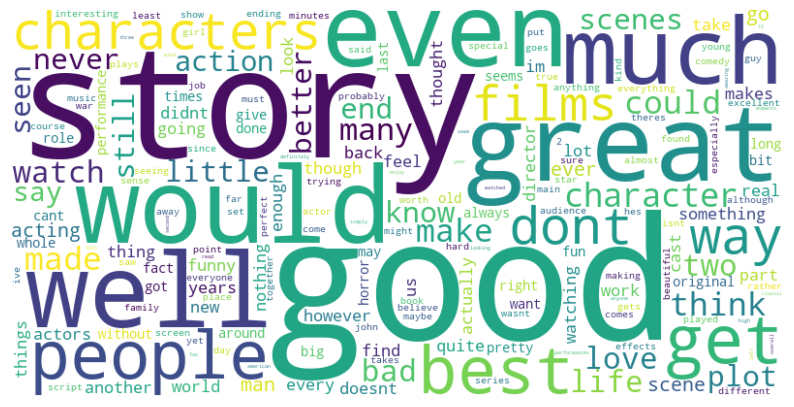

In [196]:
# Initialize counter for word frequencies
word_freq = Counter()

# Loop over each review text
for review in reviews_df['review_text']:
    # Convert to lowercase and remove punctuation
    review = review.lower().translate(translator)
    
    # Tokenize
    tokenized_review = review.split()
    
    # Remove stop words using the combined list
    filtered_words = [word for word in tokenized_review if word not in all_stopwords]
    
    # Update word frequencies
    word_freq.update(filtered_words)

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let's generate another word cloud and limit it to only movies that are in the Good and Excellent categories.

In [80]:
# Filter to only include 'Good' and 'Excellent' rating categories
filtered_reviews_df = reviews_df[reviews_df['rating_category'].isin(['Good', 'Excellent'])]

# Initialize counter for word frequencies
word_freq = Counter()

# Set custom stopwords
custom_stopwords = set(stopwords.words('english') + ['movie', 'film', 'movies', 'one', 'really', 'like', 'see', 'also', 'time', 'first', 'thats', 'good', 'would'])

# Initialize a translation table to remove punctuation
translator = str.maketrans('', '', string.punctuation)

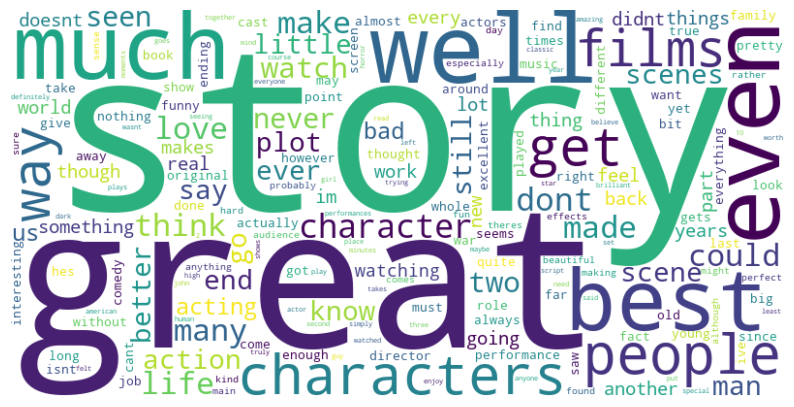

In [201]:
# Loop over each review text in the filtered dataframe
for review in filtered_reviews_df['review_text']:
    # Convert to lowercase and remove punctuation
    review = review.lower().translate(translator)
    
    # Tokenize
    tokenized_review = review.split()
    
    # Remove stop words
    filtered_words = [word for word in tokenized_review if word not in custom_stopwords]
    
    # Update word frequencies
    word_freq.update(filtered_words)

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let's generate another word cloud for the Average and Poor rating category.

In [79]:
# Filter to only include 'Average' and 'Poor' rating categories
filtered_reviews_df = reviews_df[reviews_df['rating_category'].isin(['Average', 'Poor'])]

# Initialize counter for word frequencies
word_freq = Counter()

# Define custom stopwords
custom_stopwords = set(stopwords.words('english') + ['movie', 'film', 'movies', 'one', 'really', 'like', 'see', 'also', 'time', 'first', 'thats', 'good', 'would'])

# Initialize a translation table to remove punctuation
translator = str.maketrans('', '', string.punctuation)

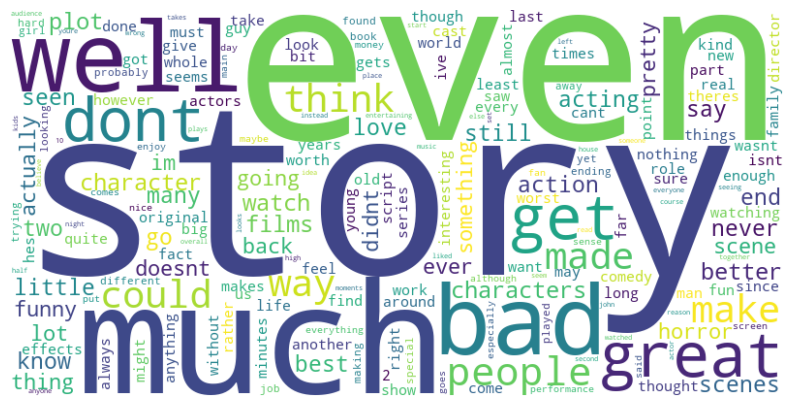

In [202]:
# Loop over each review text in the filtered data
for review in filtered_reviews_df['review_text']:
    # Convert to lowercase and remove punctuation
    review = review.lower().translate(translator)
    
    # Tokenize
    tokenized_review = review.split()
    
    # Remove stop words
    filtered_words = [word for word in tokenized_review if word not in custom_stopwords]
    
    # Update word frequencies
    word_freq.update(filtered_words)

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We can see from the different word clouds that "story" is the most prominent word in both good and bad reviews.

We haven't gained that much insight from this, so we'll have to pre-process our text data prior to modeling to see if there are any additional insights to uncover.

---

### Conclusion

We've discovered some new insights about our data, but still don't have a good idea of how predictive our features are. We'll need to run a baseline model to get a better understanding of this.

To summarize the next steps we'll be taking to run a baseline model: 

1. **Train-Test Split** We'll use an 80/20 split. 

2. **Feature Engineering on Metadata**: Planned feature engineering (one-hot encoding, binning, etc.) on the training set and apply the same transformations to test set. 

3. **Text Feature Extraction**: Use CountVectorizer or TF-IDF to fit the vectorizer on the training set and transform both the training and test sets.

4. **KNN Imputer**: Fit and transform training set, run KNN imputer to fill in the missing values for `budget` and `box_office_gross`. Then transform test set.

As a final step for this notebook, let's update the metadata_df to drop the one imdb_id that we lost from our duplicate reviews. Then we'll save our dataframes to reflect the edits that we've made here.

In [81]:
# Find common ids
common_imdb_ids = metadata_df['imdb_id'].isin(reviews_df['imdb_id'])

# Filter metadata_df to include only these IMDb IDs
filtered_metadata_df = metadata_df[common_imdb_ids]

In [82]:
filtered_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49378 entries, 0 to 49378
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   imdb_id               49378 non-null  object  
 1   title                 49378 non-null  object  
 2   actors                49378 non-null  object  
 3   directors             49378 non-null  object  
 4   genres                49378 non-null  object  
 5   language_en           49378 non-null  int64   
 6   year                  49378 non-null  int64   
 7   runtime               49378 non-null  int64   
 8   budget                17818 non-null  float64 
 9   box_office_gross      21049 non-null  float64 
 10  production_companies  49378 non-null  object  
 11  votes                 49378 non-null  int64   
 12  rating                49378 non-null  float64 
 13  rating_category       49378 non-null  category
 14  decade                49378 non-null  int64   
dtypes: cate

Great, now we'll save the dataframes.

In [211]:
# Save to json
filtered_metadata_df.to_json('data/model_data/metadata.json', orient='records', lines=True)

In [83]:
# Save to json
reviews_df.to_json('data/model_data/reviews.json', orient='records', lines=True)

#### Open Quetions 
Below are some open questions that we weren't able to sufficiently determine during EDA. We'll come back to these after baseline modeling as we look at future approaches: 
- Should budget outliers be removed? or are they indicative of the rating? 
- Should runtime outliers be removed? Or are particularly long movies indicative of a particular rating? (There are only 40 movies with runtime longer than 300 minutes, so we should be okay to drop these if needed) 
- Should we drop movies with only 1 review? Or will normalizing with a column for "number of reviews" be sufficient? 